In [1]:
# import os
# import sys
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

In [1]:
!git clone https://github.com/time-series-foundation-models/lag-llama/ 

fatal: destination path 'lag-llama' already exists and is not an empty directory.


In [2]:
cd lag-llama 

/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/benchmarks/lag-llama


/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/lag_llama_venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
pip install -r requirements.txt --quiet 


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir weights/

weights/lag-llama.ckpt


In [5]:
pip install yfinance --quiet


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install peft


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
from lag_llama.gluon.estimator import LagLlamaEstimator

/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/lag_llama_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/lag_llama_venv/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


# Test model on S&P500 from documentation Colab demo examples

### official Colab demo for zero-shot forecasting: https://colab.research.google.com/drive/1DRAzLUPxsd-0r8b-o4nlyFXrjw_ZajJJ?authuser=1#scrollTo=Mj9LXMpJ01d7&line=6&uniqifier=1 
### random medium blog: https://medium.com/@odhitom09/lag-llama-an-open-source-base-model-for-predicting-time-series-data-2e897fddf005

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_56224/4210001275.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

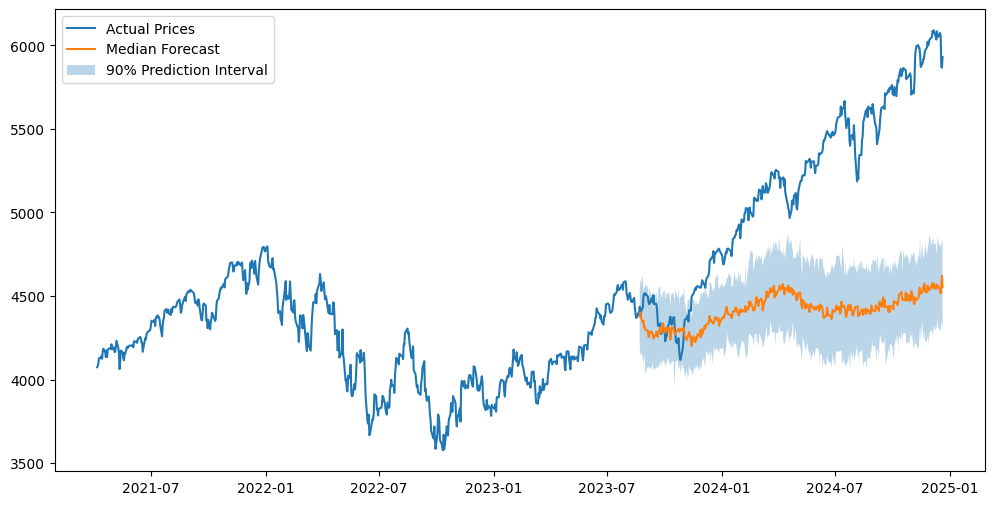

In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator

from data_snp.snp500 import snp500_daily

# Prepare the data
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]
sp500_d["Date"] = pd.to_datetime(sp500_d["Date"])

# Create the GluonTS dataset
# Flatten the 'Close' values to ensure a 1D target array
dataset = ListDataset(
    [{"start": sp500_d["Date"].iloc[0], "target": sp500_d["Close"].values.flatten()}],
    freq="1d"
)


# Define lengths
prediction_length = 336
context_length = 128

# Load the checkpoint
ckpt = torch.load("weights/lag-llama.ckpt", map_location=torch.device("mps" if torch.backends.mps.is_available() else "cpu"))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

# Initialize the model
estimator = LagLlamaEstimator(
    ckpt_path="weights/lag-llama.ckpt",
    prediction_length=prediction_length,
    context_length=context_length,
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
    device=torch.device("mps" if torch.cuda.is_available() else "cpu")
)

# Create predictor
lightning_module = estimator.create_lightning_module()
transformation = estimator.create_transformation()
predictor = estimator.create_predictor(transformation, lightning_module)

# Generate predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset,
    predictor=predictor,
    num_samples=100
)

forecasts = list(forecast_it)
tss = list(ts_it)

# Extract forecast samples
forecast_samples = forecasts[0].samples
low, median, high = np.percentile(forecast_samples, [10, 50, 90], axis=0)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(sp500_d["Date"][-prediction_length - 600:], sp500_d["Close"][-prediction_length - 600:], label="Actual Prices")
plt.plot(sp500_d["Date"][-prediction_length:], median, label="Median Forecast")
plt.fill_between(sp500_d["Date"][-prediction_length:], low, high, alpha=0.3, label="90% Prediction Interval")
plt.legend()
plt.show()

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/2194275343.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

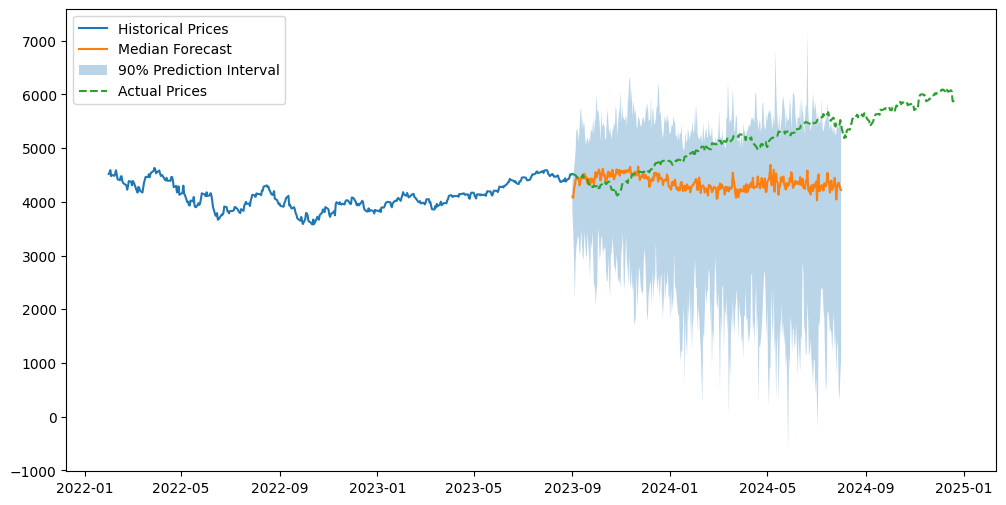

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator

from data_snp.snp500 import snp500_daily

# Set forecast start date (you can modify this)
forecast_start_date = "2023-09-01"  # Format: "YYYY-MM-DD"

# Prepare the data
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]
sp500_d["Date"] = pd.to_datetime(sp500_d["Date"])

# Find index for forecast start date
forecast_start = pd.to_datetime(forecast_start_date)
forecast_idx = sp500_d[sp500_d["Date"] <= forecast_start].index[-1]
data_up_to_forecast = sp500_d.iloc[:forecast_idx + 1]

# Create the GluonTS dataset
# Flatten the 'Close' values to ensure a 1D target array
dataset = ListDataset(
    [{"start": data_up_to_forecast["Date"].iloc[0], "target": data_up_to_forecast["Close"].values.flatten()}],
    freq="1D"
)

# Define lengths
prediction_length = 336
context_length = 128

# Load the checkpoint
ckpt = torch.load("weights/lag-llama.ckpt", map_location=torch.device("mps" if torch.backends.mps.is_available() else "cpu"))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

# Initialize the model
estimator = LagLlamaEstimator(
    ckpt_path="weights/lag-llama.ckpt",
    prediction_length=prediction_length,
    context_length=context_length,
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
    device=torch.device("mps" if torch.cuda.is_available() else "cpu")
)

# Create predictor
lightning_module = estimator.create_lightning_module()
transformation = estimator.create_transformation()
predictor = estimator.create_predictor(transformation, lightning_module)

# Generate predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset,
    predictor=predictor,
    num_samples=100
)

forecasts = list(forecast_it)
tss = list(ts_it)

# Extract forecast samples
forecast_samples = forecasts[0].samples
low, median, high = np.percentile(forecast_samples, [10, 50, 90], axis=0)

# Generate future dates for the forecast period
future_dates = pd.date_range(start=forecast_start, periods=prediction_length, freq='D')

# Plot the forecast
plt.figure(figsize=(12, 6))
# Plot historical data
plt.plot(data_up_to_forecast["Date"][-400:], data_up_to_forecast["Close"][-400:], label="Historical Prices")
# Plot forecast
plt.plot(future_dates, median, label="Median Forecast")
plt.fill_between(future_dates, low, high, alpha=0.3, label="90% Prediction Interval")
# Plot actual data for comparison if available
actual_future = sp500_d[sp500_d["Date"] >= forecast_start].iloc[:prediction_length]
if not actual_future.empty:
    plt.plot(actual_future["Date"], actual_future["Close"], '--', label="Actual Prices")
plt.legend()
plt.show()

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_56224/3660951309.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

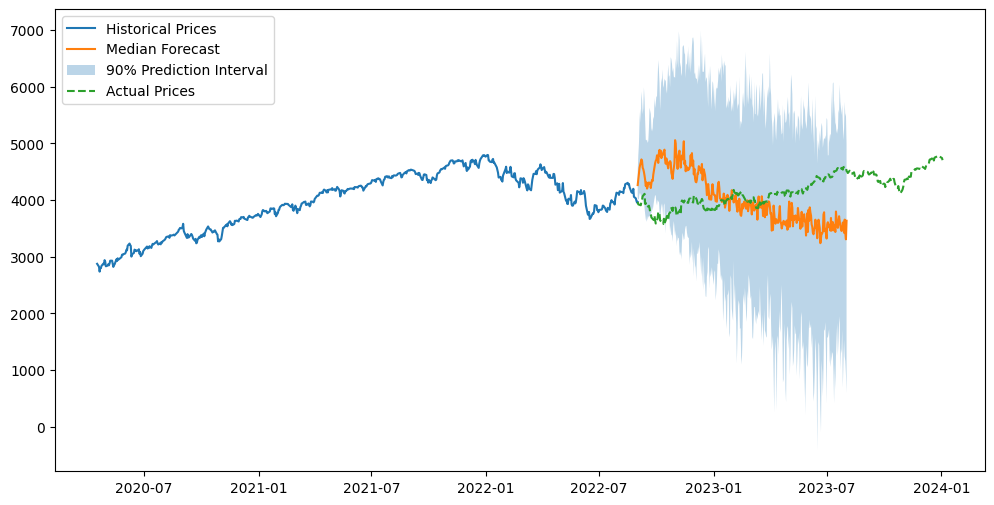

In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator

from data_snp.snp500 import snp500_daily

# Set forecast start date (you can modify this)
forecast_start_date = "2020-09-01"  # Format: "YYYY-MM-DD"

# Prepare the data
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]
sp500_d["Date"] = pd.to_datetime(sp500_d["Date"])

# Find index for forecast start date
forecast_start = pd.to_datetime(forecast_start_date)
forecast_idx = sp500_d[sp500_d["Date"] <= forecast_start].index[-1]
data_up_to_forecast = sp500_d.iloc[:forecast_idx + 1]

# Create the GluonTS dataset
# Flatten the 'Close' values to ensure a 1D target array
dataset = ListDataset(
    [{"start": data_up_to_forecast["Date"].iloc[0], "target": data_up_to_forecast["Close"].values.flatten()}],
    freq="1D"
)

# Define lengths
prediction_length = 336
context_length = 128

# Load the checkpoint
ckpt = torch.load("weights/lag-llama.ckpt", map_location=torch.device("mps" if torch.backends.mps.is_available() else "cpu"))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

# Initialize the model
estimator = LagLlamaEstimator(
    ckpt_path="weights/lag-llama.ckpt",
    prediction_length=prediction_length,
    context_length=context_length,
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
    device=torch.device("mps" if torch.cuda.is_available() else "cpu")
)

# Create predictor
lightning_module = estimator.create_lightning_module()
transformation = estimator.create_transformation()
predictor = estimator.create_predictor(transformation, lightning_module)

# Generate predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset,
    predictor=predictor,
    num_samples=100
)

forecasts = list(forecast_it)
tss = list(ts_it)

# Extract forecast samples
forecast_samples = forecasts[0].samples
low, median, high = np.percentile(forecast_samples, [10, 50, 90], axis=0)

# Generate future dates for the forecast period
future_dates = pd.date_range(start=forecast_start, periods=prediction_length, freq='D')

# Plot the forecast
plt.figure(figsize=(12, 6))
# Plot historical data
plt.plot(data_up_to_forecast["Date"][-600:], data_up_to_forecast["Close"][-600:], label="Historical Prices")
# Plot forecast
plt.plot(future_dates, median, label="Median Forecast")
plt.fill_between(future_dates, low, high, alpha=0.3, label="90% Prediction Interval")
# Plot actual data for comparison if available
actual_future = sp500_d[sp500_d["Date"] >= forecast_start].iloc[:prediction_length]
if not actual_future.empty:
    plt.plot(actual_future["Date"], actual_future["Close"], '--', label="Actual Prices")
plt.legend()
plt.show()

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_56224/749388440.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

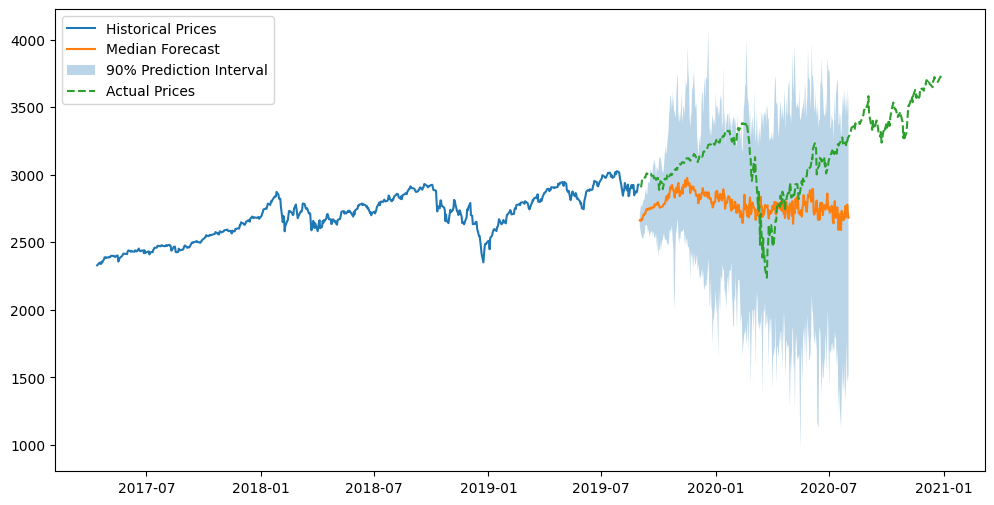

In [267]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator

from data_snp.snp500 import snp500_daily

# Set forecast start date (you can modify this)
forecast_start_date = "2019-09-01"  # Format: "YYYY-MM-DD"

# Prepare the data
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]
sp500_d["Date"] = pd.to_datetime(sp500_d["Date"])

# Find index for forecast start date
forecast_start = pd.to_datetime(forecast_start_date)
forecast_idx = sp500_d[sp500_d["Date"] <= forecast_start].index[-1]
data_up_to_forecast = sp500_d.iloc[:forecast_idx + 1]

# Create the GluonTS dataset
# Flatten the 'Close' values to ensure a 1D target array
dataset = ListDataset(
    [{"start": data_up_to_forecast["Date"].iloc[0], "target": data_up_to_forecast["Close"].values.flatten()}],
    freq="1D"
)

# Define lengths
prediction_length = 336
context_length = 128

# Load the checkpoint
ckpt = torch.load("weights/lag-llama.ckpt", map_location=torch.device("mps" if torch.backends.mps.is_available() else "cpu"))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

# Initialize the model
estimator = LagLlamaEstimator(
    ckpt_path="weights/lag-llama.ckpt",
    prediction_length=prediction_length,
    context_length=context_length,
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
    device=torch.device("mps" if torch.cuda.is_available() else "cpu")
)

# Create predictor
lightning_module = estimator.create_lightning_module()
transformation = estimator.create_transformation()
predictor = estimator.create_predictor(transformation, lightning_module)

# Generate predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset,
    predictor=predictor,
    num_samples=100
)

forecasts = list(forecast_it)
tss = list(ts_it)

# Extract forecast samples
forecast_samples = forecasts[0].samples
low, median, high = np.percentile(forecast_samples, [10, 50, 90], axis=0)

# Generate future dates for the forecast period
future_dates = pd.date_range(start=forecast_start, periods=prediction_length, freq='D')

# Plot the forecast
plt.figure(figsize=(12, 6))
# Plot historical data
plt.plot(data_up_to_forecast["Date"][-600:], data_up_to_forecast["Close"][-600:], label="Historical Prices")
# Plot forecast
plt.plot(future_dates, median, label="Median Forecast")
plt.fill_between(future_dates, low, high, alpha=0.3, label="90% Prediction Interval")
# Plot actual data for comparison if available
actual_future = sp500_d[sp500_d["Date"] >= forecast_start].iloc[:prediction_length]
if not actual_future.empty:
    plt.plot(actual_future["Date"], actual_future["Close"], '--', label="Actual Prices")
plt.legend()
plt.show()

# Testing the model: context 720 prediction 96

In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator

# Parameters
CONTEXT_WINDOW = 128  # Context length for model
PREDICTION_STEPS = 336  # Forecast steps
FORECAST_DATE = '2021-09-09'  # Fixed date to start forecasting

# Prepare the data
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]
sp500_d["Date"] = pd.to_datetime(sp500_d["Date"])

# Find the start index based on the fixed forecast date
forecast_start_idx = sp500_d[sp500_d['Date'] <= pd.Timestamp(FORECAST_DATE)].index[-1]

# Validate context window
if forecast_start_idx < CONTEXT_WINDOW - 1:
    raise ValueError("Not enough data before the forecast start date to create the context window.")

# Adjust context and forecast slices
context_start_idx = max(0, forecast_start_idx - CONTEXT_WINDOW + 1)
context_data = sp500_d['Close'].iloc[context_start_idx:forecast_start_idx + 1].to_numpy().flatten()
context_start_date = sp500_d['Date'].iloc[context_start_idx]

# Validate forecast range
max_forecast_steps = len(sp500_d) - forecast_start_idx - 1
if PREDICTION_STEPS > max_forecast_steps:
    raise ValueError(f"Not enough data for {PREDICTION_STEPS} forecast steps. Max allowed is {max_forecast_steps}.")

# Create dataset
dataset = ListDataset(
    [{"start": context_start_date, "target": context_data}],
    freq="1D"
)


# Load the checkpoint and initialize the estimator
ckpt = torch.load("weights/lag-llama.ckpt", map_location=torch.device("mps" if torch.mps.is_available() else "cpu"))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
    ckpt_path="weights/lag-llama.ckpt",
    prediction_length=PREDICTION_STEPS,
    context_length=CONTEXT_WINDOW,
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
    device=torch.device("mps" if torch.mps.is_available() else "cpu")
)

# Create the predictor
lightning_module = estimator.create_lightning_module()
transformation = estimator.create_transformation()
predictor = estimator.create_predictor(transformation, lightning_module)

# Generate predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset,
    predictor=predictor,
    num_samples=100
)

forecasts = list(forecast_it)
tss = list(ts_it)

# Extract forecast samples
forecast_samples = forecasts[0].samples
low, median, high = np.percentile(forecast_samples, [10, 50, 90], axis=0)

# Plot the forecast with fixed start point and iloc-controlled range
plt.figure(figsize=(12, 6))

# Plot historical data for context
context_range = sp500_d.iloc[forecast_start_idx - CONTEXT_WINDOW:forecast_start_idx]
plt.plot(context_range["Date"], context_range["Close"], label="Historical Data", alpha=0.7)

# Plot actual values during the forecast period
forecast_range = sp500_d.iloc[forecast_start_idx:forecast_start_idx + PREDICTION_STEPS]
plt.plot(forecast_range["Date"], forecast_range["Close"], label="Actual Prices", color="green")

# Plot forecast
forecast_dates = sp500_d["Date"].iloc[forecast_start_idx:forecast_start_idx + PREDICTION_STEPS]
plt.plot(forecast_dates, median, label="Median Forecast", color="tomato")
plt.fill_between(forecast_dates, low, high, alpha=0.3, label="90% Prediction Interval", color="tomato")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("S&P 500 Close Prices")
plt.title(f"S&P 500 Forecast from {FORECAST_DATE}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_56224/1288950766.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

AssertionError: 

# Sliding Window

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/944862496.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m


Sliding Window Forecast Metrics:
MAE: 83.1954
MSE: 9566.6304
RMSE: 97.8092
MAPE: 1.8513
SMAPE: 1.8281
MASE: N/A


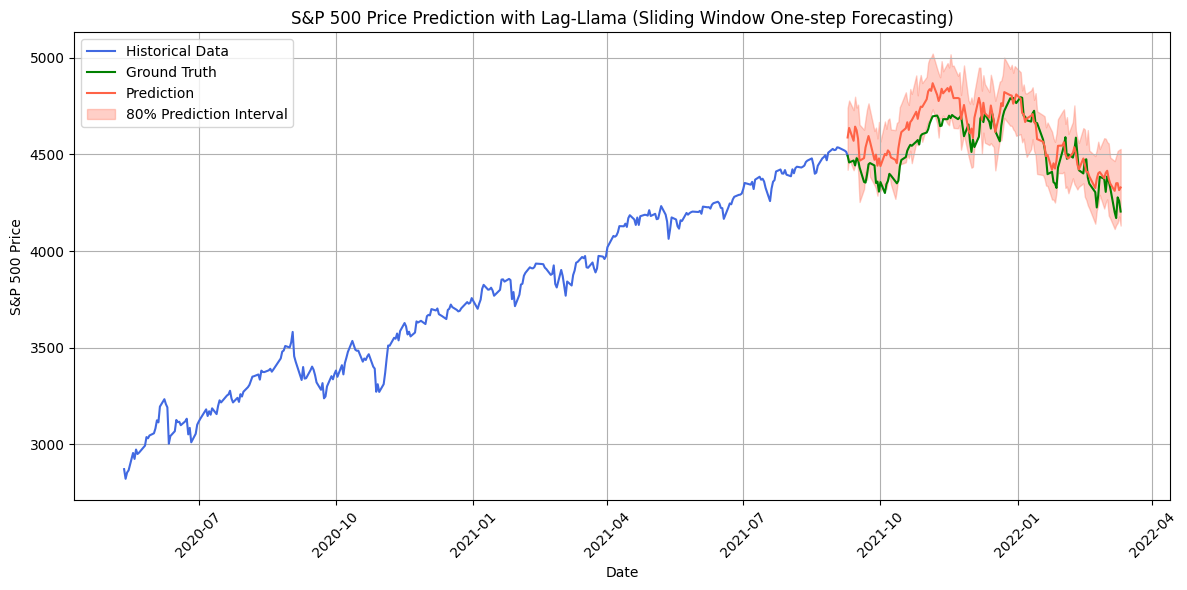

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions

CONTEXT_WINDOW = 336
FORECAST_STEPS = 128  # Number of one-step forecasts to make

def get_lag_llama_predictions(dataset, prediction_length, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("weights/lag-llama.ckpt", map_location=torch.device("mps" if torch.mps.is_available() else "cpu"))
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
    
    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }
    
    estimator = LagLlamaEstimator(
        ckpt_path="weights/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,
        device=torch.device("mps" if torch.mps.is_available() else "cpu")
    )
    
    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    
    return forecasts, tss

def generate_single_forecast(context_data, start_date):
    """Generate a single one-step forecast"""
    # Ensure context_data is 1D
    context_data = np.asarray(context_data).flatten()
    
    # Create ListDataset for the current context window
    dataset = ListDataset(
        [{"start": start_date, "target": context_data}],
        freq="1d"
    )
    
    # Generate forecast
    forecasts, _ = get_lag_llama_predictions(
        dataset=dataset,
        prediction_length=1,  # One-step forecast
        context_length=CONTEXT_WINDOW,
        use_rope_scaling=True,
        num_samples=100
    )
    
    forecast_samples = forecasts[0].samples
    
    # Extract quantiles
    low, median, high = np.percentile(forecast_samples, [10, 50, 90], axis=0)
    return low[0], median[0], high[0]  # Return single values instead of arrays

def generate_sliding_window_forecasts(data, start_idx):
    """Generate forecasts using sliding window approach"""
    all_forecasts = {
        'median': [],
        'low': [],
        'high': [],
        'dates': []
    }
    
    for i in range(FORECAST_STEPS):
        # Get current context window
        current_idx = start_idx + i
        # Ensure we get a 1D array of the closing prices
        context_data = data['Close'].iloc[current_idx - CONTEXT_WINDOW - 1 :current_idx - 1].to_numpy()
        context_start_date = data['Date'].iloc[current_idx - CONTEXT_WINDOW - 1]
        
        # Generate forecast for next day
        low, median, high = generate_single_forecast(context_data, context_start_date)
        
        # Store results
        all_forecasts['median'].append(median)
        all_forecasts['low'].append(low)
        all_forecasts['high'].append(high)
        all_forecasts['dates'].append(data['Date'].iloc[current_idx])
    
    return all_forecasts

def plot_forecast_with_sliding_window(data, start_idx, forecasts):
    """Modified plotting function for sliding window forecasts"""
    plt.figure(figsize=(12, 6))
    
    # Plot historical context (last window before forecasts begin)
    context_data = data.iloc[start_idx - CONTEXT_WINDOW + 1:start_idx + 1]
    plt.plot(
        context_data['Date'],
        context_data['Close'],
        color='royalblue',
        label='Historical Data'
    )
    
    # Plot actual prices for forecast period
    actual_data = data.iloc[start_idx :start_idx + FORECAST_STEPS]
    plt.plot(
        actual_data['Date'],
        actual_data['Close'],
        color='green',
        label='Ground Truth'
    )
    
    # Plot forecasts
    forecast_dates = forecasts['dates']
    plt.plot(
        forecast_dates,
        forecasts['median'],
        color='tomato',
        label='Prediction'
    )
    plt.fill_between(
        forecast_dates,
        forecasts['low'],
        forecasts['high'],
        color='tomato',
        alpha=0.3,
        label='80% Prediction Interval'
    )
    
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.title('S&P 500 Price Prediction with Lag-Llama (Sliding Window One-step Forecasting)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def calculate_sliding_window_metrics(actual_values, predicted_values):
    """Calculate metrics for sliding window predictions"""
    metrics = calculate_metrics(
        actual_values,
        predicted_values,
        insample=None  # We don't need insample data for sliding window evaluation
    )
    return metrics

# Main execution
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]
sp500_d["Date"] = pd.to_datetime(sp500_d["Date"])

# Select start index for forecasting (e.g., for 2021-09-09)
target_date = pd.Timestamp('2021-09-09')
start_idx = sp500_d[sp500_d['Date'] <= target_date].index[-1]

# Generate forecasts using sliding window
forecasts = generate_sliding_window_forecasts(sp500_d, start_idx)

# Calculate metrics
actual_values = sp500_d['Close'].iloc[start_idx + 1:start_idx + FORECAST_STEPS + 1].values
metrics = calculate_sliding_window_metrics(actual_values, forecasts['median'])

# Print metrics
print("\nSliding Window Forecast Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot results
plot_forecast_with_sliding_window(sp500_d, start_idx, forecasts)

Forecast date: 2021-09-09 00:00:00
Context window: 2020-05-11 00:00:00 to 2021-09-08 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-09-10 00:00:00
Context window: 2020-05-12 00:00:00 to 2021-09-09 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-09-13 00:00:00
Context window: 2020-05-13 00:00:00 to 2021-09-10 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-09-14 00:00:00
Context window: 2020-05-14 00:00:00 to 2021-09-13 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-09-15 00:00:00
Context window: 2020-05-15 00:00:00 to 2021-09-14 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-09-16 00:00:00
Context window: 2020-05-18 00:00:00 to 2021-09-15 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-09-17 00:00:00
Context window: 2020-05-19 00:00:00 to 2021-09-16 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-09-20 00:00:00
Context window: 2020-05-20 00:00:00 to 2021-09-17 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-09-21 00:00:00
Context window: 2020-05-21 00:00:00 to 2021-09-20 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-09-22 00:00:00
Context window: 2020-05-22 00:00:00 to 2021-09-21 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-09-23 00:00:00
Context window: 2020-05-26 00:00:00 to 2021-09-22 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-09-24 00:00:00
Context window: 2020-05-27 00:00:00 to 2021-09-23 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-09-27 00:00:00
Context window: 2020-05-28 00:00:00 to 2021-09-24 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-09-28 00:00:00
Context window: 2020-05-29 00:00:00 to 2021-09-27 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-09-29 00:00:00
Context window: 2020-06-01 00:00:00 to 2021-09-28 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-09-30 00:00:00
Context window: 2020-06-02 00:00:00 to 2021-09-29 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-10-01 00:00:00
Context window: 2020-06-03 00:00:00 to 2021-09-30 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-10-04 00:00:00
Context window: 2020-06-04 00:00:00 to 2021-10-01 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-10-05 00:00:00
Context window: 2020-06-05 00:00:00 to 2021-10-04 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-10-06 00:00:00
Context window: 2020-06-08 00:00:00 to 2021-10-05 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-10-07 00:00:00
Context window: 2020-06-09 00:00:00 to 2021-10-06 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-10-08 00:00:00
Context window: 2020-06-10 00:00:00 to 2021-10-07 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-10-11 00:00:00
Context window: 2020-06-11 00:00:00 to 2021-10-08 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-10-12 00:00:00
Context window: 2020-06-12 00:00:00 to 2021-10-11 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-10-13 00:00:00
Context window: 2020-06-15 00:00:00 to 2021-10-12 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-10-14 00:00:00
Context window: 2020-06-16 00:00:00 to 2021-10-13 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-10-15 00:00:00
Context window: 2020-06-17 00:00:00 to 2021-10-14 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-10-18 00:00:00
Context window: 2020-06-18 00:00:00 to 2021-10-15 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-10-19 00:00:00
Context window: 2020-06-19 00:00:00 to 2021-10-18 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-10-20 00:00:00
Context window: 2020-06-22 00:00:00 to 2021-10-19 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-10-21 00:00:00
Context window: 2020-06-23 00:00:00 to 2021-10-20 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-10-22 00:00:00
Context window: 2020-06-24 00:00:00 to 2021-10-21 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-10-25 00:00:00
Context window: 2020-06-25 00:00:00 to 2021-10-22 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-10-26 00:00:00
Context window: 2020-06-26 00:00:00 to 2021-10-25 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-10-27 00:00:00
Context window: 2020-06-29 00:00:00 to 2021-10-26 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-10-28 00:00:00
Context window: 2020-06-30 00:00:00 to 2021-10-27 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-10-29 00:00:00
Context window: 2020-07-01 00:00:00 to 2021-10-28 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-11-01 00:00:00
Context window: 2020-07-02 00:00:00 to 2021-10-29 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-11-02 00:00:00
Context window: 2020-07-06 00:00:00 to 2021-11-01 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-11-03 00:00:00
Context window: 2020-07-07 00:00:00 to 2021-11-02 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-11-04 00:00:00
Context window: 2020-07-08 00:00:00 to 2021-11-03 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-11-05 00:00:00
Context window: 2020-07-09 00:00:00 to 2021-11-04 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-11-08 00:00:00
Context window: 2020-07-10 00:00:00 to 2021-11-05 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-11-09 00:00:00
Context window: 2020-07-13 00:00:00 to 2021-11-08 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-11-10 00:00:00
Context window: 2020-07-14 00:00:00 to 2021-11-09 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-11-11 00:00:00
Context window: 2020-07-15 00:00:00 to 2021-11-10 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-11-12 00:00:00
Context window: 2020-07-16 00:00:00 to 2021-11-11 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-11-15 00:00:00
Context window: 2020-07-17 00:00:00 to 2021-11-12 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-11-16 00:00:00
Context window: 2020-07-20 00:00:00 to 2021-11-15 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-11-17 00:00:00
Context window: 2020-07-21 00:00:00 to 2021-11-16 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-11-18 00:00:00
Context window: 2020-07-22 00:00:00 to 2021-11-17 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-11-19 00:00:00
Context window: 2020-07-23 00:00:00 to 2021-11-18 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-11-22 00:00:00
Context window: 2020-07-24 00:00:00 to 2021-11-19 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-11-23 00:00:00
Context window: 2020-07-27 00:00:00 to 2021-11-22 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-11-24 00:00:00
Context window: 2020-07-28 00:00:00 to 2021-11-23 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-11-26 00:00:00
Context window: 2020-07-29 00:00:00 to 2021-11-24 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-11-29 00:00:00
Context window: 2020-07-30 00:00:00 to 2021-11-26 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-11-30 00:00:00
Context window: 2020-07-31 00:00:00 to 2021-11-29 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-12-01 00:00:00
Context window: 2020-08-03 00:00:00 to 2021-11-30 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-12-02 00:00:00
Context window: 2020-08-04 00:00:00 to 2021-12-01 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-12-03 00:00:00
Context window: 2020-08-05 00:00:00 to 2021-12-02 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-12-06 00:00:00
Context window: 2020-08-06 00:00:00 to 2021-12-03 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-12-07 00:00:00
Context window: 2020-08-07 00:00:00 to 2021-12-06 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-12-08 00:00:00
Context window: 2020-08-10 00:00:00 to 2021-12-07 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-12-09 00:00:00
Context window: 2020-08-11 00:00:00 to 2021-12-08 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-12-10 00:00:00
Context window: 2020-08-12 00:00:00 to 2021-12-09 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-12-13 00:00:00
Context window: 2020-08-13 00:00:00 to 2021-12-10 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-12-14 00:00:00
Context window: 2020-08-14 00:00:00 to 2021-12-13 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-12-15 00:00:00
Context window: 2020-08-17 00:00:00 to 2021-12-14 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-12-16 00:00:00
Context window: 2020-08-18 00:00:00 to 2021-12-15 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-12-17 00:00:00
Context window: 2020-08-19 00:00:00 to 2021-12-16 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-12-20 00:00:00
Context window: 2020-08-20 00:00:00 to 2021-12-17 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-12-21 00:00:00
Context window: 2020-08-21 00:00:00 to 2021-12-20 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-12-22 00:00:00
Context window: 2020-08-24 00:00:00 to 2021-12-21 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-12-23 00:00:00
Context window: 2020-08-25 00:00:00 to 2021-12-22 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-12-27 00:00:00
Context window: 2020-08-26 00:00:00 to 2021-12-23 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-12-28 00:00:00
Context window: 2020-08-27 00:00:00 to 2021-12-27 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-12-29 00:00:00
Context window: 2020-08-28 00:00:00 to 2021-12-28 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-12-30 00:00:00
Context window: 2020-08-31 00:00:00 to 2021-12-29 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2021-12-31 00:00:00
Context window: 2020-09-01 00:00:00 to 2021-12-30 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-01-03 00:00:00
Context window: 2020-09-02 00:00:00 to 2021-12-31 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-01-04 00:00:00
Context window: 2020-09-03 00:00:00 to 2022-01-03 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-01-05 00:00:00
Context window: 2020-09-04 00:00:00 to 2022-01-04 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-01-06 00:00:00
Context window: 2020-09-08 00:00:00 to 2022-01-05 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-01-07 00:00:00
Context window: 2020-09-09 00:00:00 to 2022-01-06 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-01-10 00:00:00
Context window: 2020-09-10 00:00:00 to 2022-01-07 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-01-11 00:00:00
Context window: 2020-09-11 00:00:00 to 2022-01-10 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-01-12 00:00:00
Context window: 2020-09-14 00:00:00 to 2022-01-11 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-01-13 00:00:00
Context window: 2020-09-15 00:00:00 to 2022-01-12 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-01-14 00:00:00
Context window: 2020-09-16 00:00:00 to 2022-01-13 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-01-18 00:00:00
Context window: 2020-09-17 00:00:00 to 2022-01-14 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-01-19 00:00:00
Context window: 2020-09-18 00:00:00 to 2022-01-18 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-01-20 00:00:00
Context window: 2020-09-21 00:00:00 to 2022-01-19 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-01-21 00:00:00
Context window: 2020-09-22 00:00:00 to 2022-01-20 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-01-24 00:00:00
Context window: 2020-09-23 00:00:00 to 2022-01-21 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-01-25 00:00:00
Context window: 2020-09-24 00:00:00 to 2022-01-24 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-01-26 00:00:00
Context window: 2020-09-25 00:00:00 to 2022-01-25 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-01-27 00:00:00
Context window: 2020-09-28 00:00:00 to 2022-01-26 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-01-28 00:00:00
Context window: 2020-09-29 00:00:00 to 2022-01-27 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-01-31 00:00:00
Context window: 2020-09-30 00:00:00 to 2022-01-28 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-02-01 00:00:00
Context window: 2020-10-01 00:00:00 to 2022-01-31 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-02-02 00:00:00
Context window: 2020-10-02 00:00:00 to 2022-02-01 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-02-03 00:00:00
Context window: 2020-10-05 00:00:00 to 2022-02-02 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-02-04 00:00:00
Context window: 2020-10-06 00:00:00 to 2022-02-03 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-02-07 00:00:00
Context window: 2020-10-07 00:00:00 to 2022-02-04 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-02-08 00:00:00
Context window: 2020-10-08 00:00:00 to 2022-02-07 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-02-09 00:00:00
Context window: 2020-10-09 00:00:00 to 2022-02-08 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-02-10 00:00:00
Context window: 2020-10-12 00:00:00 to 2022-02-09 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-02-11 00:00:00
Context window: 2020-10-13 00:00:00 to 2022-02-10 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-02-14 00:00:00
Context window: 2020-10-14 00:00:00 to 2022-02-11 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-02-15 00:00:00
Context window: 2020-10-15 00:00:00 to 2022-02-14 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-02-16 00:00:00
Context window: 2020-10-16 00:00:00 to 2022-02-15 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-02-17 00:00:00
Context window: 2020-10-19 00:00:00 to 2022-02-16 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-02-18 00:00:00
Context window: 2020-10-20 00:00:00 to 2022-02-17 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-02-22 00:00:00
Context window: 2020-10-21 00:00:00 to 2022-02-18 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-02-23 00:00:00
Context window: 2020-10-22 00:00:00 to 2022-02-22 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-02-24 00:00:00
Context window: 2020-10-23 00:00:00 to 2022-02-23 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-02-25 00:00:00
Context window: 2020-10-26 00:00:00 to 2022-02-24 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-02-28 00:00:00
Context window: 2020-10-27 00:00:00 to 2022-02-25 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-03-01 00:00:00
Context window: 2020-10-28 00:00:00 to 2022-02-28 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-03-02 00:00:00
Context window: 2020-10-29 00:00:00 to 2022-03-01 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-03-03 00:00:00
Context window: 2020-10-30 00:00:00 to 2022-03-02 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-03-04 00:00:00
Context window: 2020-11-02 00:00:00 to 2022-03-03 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-03-07 00:00:00
Context window: 2020-11-03 00:00:00 to 2022-03-04 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-03-08 00:00:00
Context window: 2020-11-04 00:00:00 to 2022-03-07 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-03-09 00:00:00
Context window: 2020-11-05 00:00:00 to 2022-03-08 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-03-10 00:00:00
Context window: 2020-11-06 00:00:00 to 2022-03-09 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m

Forecast date: 2022-03-11 00:00:00
Context window: 2020-11-09 00:00:00 to 2022-03-10 00:00:00
Elements in window: 336



/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10591/915756127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m


Sliding Window Forecast Metrics:
MAE: 69.2752
MSE: 7854.7092
RMSE: 88.6268
MAPE: 1.5540
SMAPE: 1.5430
MASE: N/A


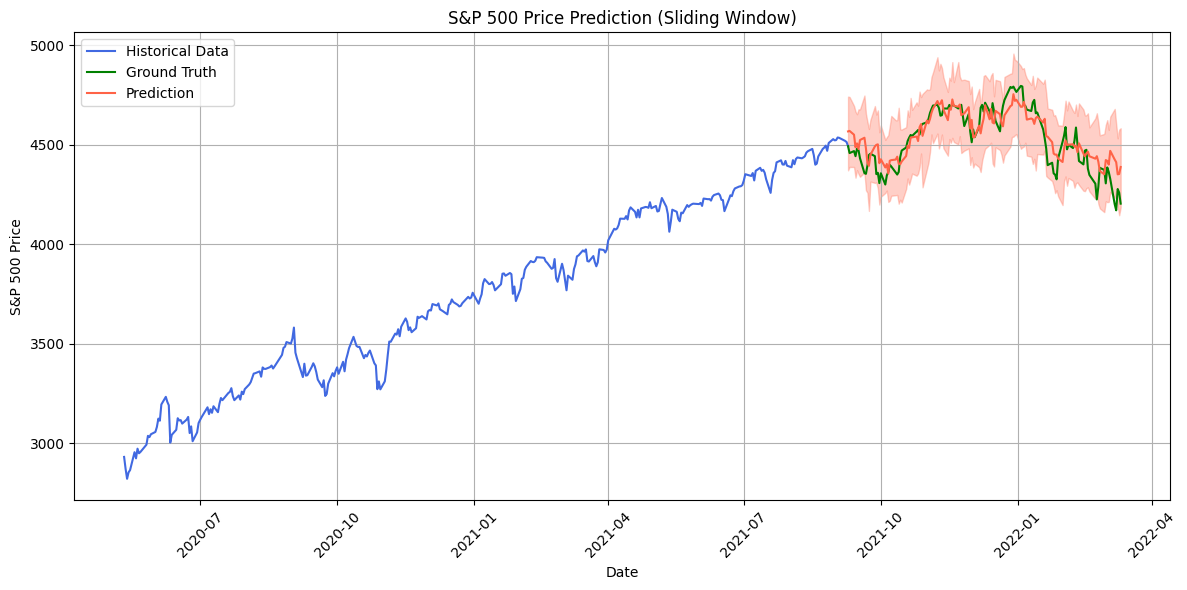

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions

CONTEXT_WINDOW = 336
FORECAST_STEPS = 128  # Number of one-step forecasts to make

def get_lag_llama_predictions(dataset, prediction_length, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("weights/lag-llama.ckpt", map_location=torch.device("mps" if torch.mps.is_available() else "cpu"))
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
    
    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }
    
    estimator = LagLlamaEstimator(
        ckpt_path="weights/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,
        device=torch.device("mps" if torch.mps.is_available() else "cpu")
    )
    
    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    
    return forecasts, tss

def generate_single_forecast(context_data, start_date):
    """Generate a single one-step forecast"""
    # Ensure context_data is 1D
    context_data = np.asarray(context_data).flatten()
    
    # Create ListDataset for the current context window
    dataset = ListDataset(
        [{"start": start_date, "target": context_data}],
        freq="1d"
    )
    
    # Generate forecast
    forecasts, _ = get_lag_llama_predictions(
        dataset=dataset,
        prediction_length=1,  # One-step forecast
        context_length=CONTEXT_WINDOW,
        use_rope_scaling=True,
        num_samples=100
    )
    
    forecast_samples = forecasts[0].samples
    
    # Extract quantiles
    low, median, high = np.percentile(forecast_samples, [10, 50, 90], axis=0)
    return low[0], median[0], high[0]  # Return single values instead of arrays

def generate_sliding_window_forecasts(data, start_idx):
    """Fixed sliding window implementation"""
    all_forecasts = {
        'median': [],
        'low': [],
        'high': [],
        'dates': []
    }
    
    for i in range(FORECAST_STEPS):
        current_idx = start_idx + i
        
        # Get context window with exact CONTEXT_WINDOW elements
        context_start = current_idx - CONTEXT_WINDOW
        context_data = data['Close'].iloc[context_start:current_idx].to_numpy()
        context_start_date = data['Date'].iloc[context_start]
        
        print(f"Forecast date: {data['Date'].iloc[current_idx]}")
        print(f"Context window: {data['Date'].iloc[context_start]} to {data['Date'].iloc[current_idx - 1]}")
        print(f"Elements in window: {len(context_data)}\n")
        
        # Validate window size
        if len(context_data) != CONTEXT_WINDOW:
            raise ValueError(f"Invalid context window size: {len(context_data)}")
        
        # Generate forecast
        low, median, high = generate_single_forecast(context_data, context_start_date)
        
        # Store results
        all_forecasts['median'].append(median)
        all_forecasts['low'].append(low)
        all_forecasts['high'].append(high)
        all_forecasts['dates'].append(data['Date'].iloc[current_idx])
    
    return all_forecasts

def plot_forecast_with_sliding_window(data, start_idx, forecasts):
    """Fixed visualization"""
    plt.figure(figsize=(12, 6))
    
    # Plot historical context
    context_data = data.iloc[start_idx - CONTEXT_WINDOW:start_idx + 1]
    plt.plot(context_data['Date'], context_data['Close'], color='royalblue', label='Historical Data')
    
    # Plot actual prices
    actual_data = data.iloc[start_idx:start_idx + FORECAST_STEPS]
    plt.plot(actual_data['Date'], actual_data['Close'], color='green', label='Ground Truth')
    
    # Plot forecasts
    plt.plot(forecasts['dates'], forecasts['median'], color='tomato', label='Prediction')
    plt.fill_between(forecasts['dates'], forecasts['low'], forecasts['high'], color='tomato', alpha=0.3)
    
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.title('S&P 500 Price Prediction (Sliding Window)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def calculate_sliding_window_metrics(actual_values, predicted_values):
    """Calculate metrics for sliding window predictions"""
    metrics = calculate_metrics(
        actual_values,
        predicted_values,
        insample=None
    )
    return metrics

# Main execution
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]
sp500_d["Date"] = pd.to_datetime(sp500_d["Date"])

# Select start index for forecasting (e.g., for 2021-09-09)
target_date = pd.Timestamp('2021-09-09')
start_idx = sp500_d[sp500_d['Date'] <= target_date].index[-1]

# Generate forecasts using sliding window
forecasts = generate_sliding_window_forecasts(sp500_d, start_idx)

# Calculate metrics
actual_values = sp500_d['Close'].iloc[start_idx + 1:start_idx + FORECAST_STEPS + 1].values
metrics = calculate_sliding_window_metrics(actual_values, forecasts['median'])

# Print metrics
print("\nSliding Window Forecast Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot results
plot_forecast_with_sliding_window(sp500_d, start_idx, forecasts)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions

CONTEXT_WINDOW = 336
FORECAST_STEPS = 128  # Number of one-step forecasts to make

def get_lag_llama_predictions(dataset, prediction_length, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("weights/lag-llama.ckpt", map_location=torch.device("mps" if torch.mps.is_available() else "cpu"))
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
    
    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }
    
    estimator = LagLlamaEstimator(
        ckpt_path="weights/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,
        device=torch.device("mps" if torch.mps.is_available() else "cpu")
    )
    
    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    
    return forecasts, tss

def generate_single_forecast(context_data, start_date):
    """Generate a single one-step forecast"""
    # Ensure context_data is 1D
    context_data = np.asarray(context_data).flatten()
    
    # Create ListDataset for the current context window
    dataset = ListDataset(
        [{"start": start_date, "target": context_data}],
        freq="1d"
    )
    
    # Generate forecast
    forecasts, _ = get_lag_llama_predictions(
        dataset=dataset,
        prediction_length=1,  # One-step forecast
        context_length=CONTEXT_WINDOW,
        use_rope_scaling=True,
        num_samples=100
    )
    
    forecast_samples = forecasts[0].samples
    
    # Extract quantiles
    low, median, high = np.percentile(forecast_samples, [10, 50, 90], axis=0)
    return low[0], median[0], high[0]  # Return single values instead of arrays

def generate_sliding_window_forecasts(data, start_idx):
    """Generate forecasts using sliding window approach"""
    all_forecasts = {
        'median': [],
        'low': [],
        'high': [],
        'dates': []
    }
    
    for i in range(FORECAST_STEPS):
        # Get current context window
        current_idx = start_idx + i
        # Ensure we get a 1D array of the closing prices
        context_data = data['Close'].iloc[current_idx - CONTEXT_WINDOW - 1 :current_idx - 1].to_numpy()
        context_start_date = data['Date'].iloc[current_idx - CONTEXT_WINDOW - 1]
        
        # Generate forecast for next day
        low, median, high = generate_single_forecast(context_data, context_start_date)
        
        # Store results
        all_forecasts['median'].append(median)
        all_forecasts['low'].append(low)
        all_forecasts['high'].append(high)
        all_forecasts['dates'].append(data['Date'].iloc[current_idx])
    
    return all_forecasts

def plot_forecast_with_sliding_window(data, start_idx, forecasts):
    """Modified plotting function for sliding window forecasts"""
    plt.figure(figsize=(12, 6))
    
    # Plot historical context (last window before forecasts begin)
    context_data = data.iloc[start_idx - CONTEXT_WINDOW + 1:start_idx + 1]
    plt.plot(
        context_data['Date'],
        context_data['Close'],
        color='royalblue',
        label='Historical Data'
    )
    
    # Plot actual prices for forecast period
    actual_data = data.iloc[start_idx :start_idx + FORECAST_STEPS]
    plt.plot(
        actual_data['Date'],
        actual_data['Close'],
        color='green',
        label='Ground Truth'
    )
    
    # Plot forecasts
    forecast_dates = forecasts['dates']
    plt.plot(
        forecast_dates,
        forecasts['median'],
        color='tomato',
        label='Prediction'
    )
    plt.fill_between(
        forecast_dates,
        forecasts['low'],
        forecasts['high'],
        color='tomato',
        alpha=0.3,
        label='80% Prediction Interval'
    )
    
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.title('S&P 500 Price Prediction with Lag-Llama (Sliding Window One-step Forecasting)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def calculate_sliding_window_metrics(actual_values, predicted_values):
    """Calculate metrics for sliding window predictions"""
    metrics = calculate_metrics(
        actual_values,
        predicted_values,
        insample=None  # We don't need insample data for sliding window evaluation
    )
    return metrics

# Main execution
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]
sp500_d["Date"] = pd.to_datetime(sp500_d["Date"])

# Select start index for forecasting (e.g., for 2021-09-09)
target_date = pd.Timestamp('2021-09-09')
start_idx = sp500_d[sp500_d['Date'] <= target_date].index[-1]

# Generate forecasts using sliding window
forecasts = generate_sliding_window_forecasts(sp500_d, start_idx)

# Calculate metrics
actual_values = sp500_d['Close'].iloc[start_idx + 1:start_idx + FORECAST_STEPS + 1].values
metrics = calculate_sliding_window_metrics(actual_values, forecasts['median'])

# Print metrics
print("\nSliding Window Forecast Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot results
plot_forecast_with_sliding_window(sp500_d, start_idx, forecasts)

# Recursive

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_56224/89652562.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", ma


Sliding Window Forecast Metrics:
MAE: 393.5482
MSE: 241375.1805
RMSE: 491.2995
MAPE: 8.9041
SMAPE: 8.3211
MASE: N/A


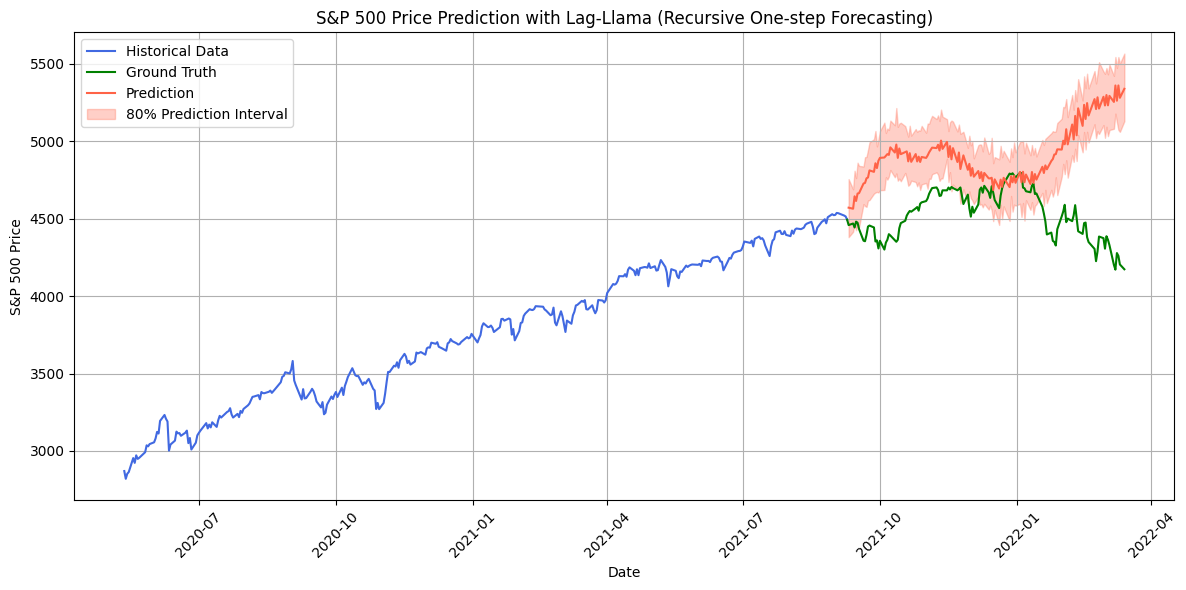

In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions

CONTEXT_WINDOW = 336
FORECAST_STEPS = 128  # Number of one-step forecasts to make

def get_lag_llama_predictions(dataset, prediction_length, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("weights/lag-llama.ckpt", map_location=torch.device("mps" if torch.mps.is_available() else "cpu"))
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
    
    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }
    
    estimator = LagLlamaEstimator(
        ckpt_path="weights/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,
        device=torch.device("mps" if torch.mps.is_available() else "cpu")
    )
    
    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    
    return forecasts, tss

def generate_single_forecast(context_data, start_date):
    """Generate a single one-step forecast"""
    # Ensure context_data is 1D
    context_data = np.asarray(context_data).flatten()
    
    # Create ListDataset for the current context window
    dataset = ListDataset(
        [{"start": start_date, "target": context_data}],
        freq="D"
    )
    
    # Generate forecast
    forecasts, _ = get_lag_llama_predictions(
        dataset=dataset,
        prediction_length=1,  # One-step forecast
        context_length=CONTEXT_WINDOW,
        use_rope_scaling=True,
        num_samples=100
    )
    
    forecast_samples = forecasts[0].samples
    
    # Extract quantiles
    low, median, high = np.percentile(forecast_samples, [10, 50, 90], axis=0)
    return low[0], median[0], high[0]  # Return single values instead of arrays

def generate_recursive_forecasts(data, start_idx):
    """Generate forecasts using recursive approach (including predictions while sliding window)"""
    all_forecasts = {
        'median': [],
        'low': [],
        'high': [],
        'dates': []
    }
    
    # Initialize tracking variables
    predictions = []  # Store all predictions as we make them
    
    for i in range(FORECAST_STEPS):
        current_idx = start_idx + i
        
        # Build context window combining historical data and previous predictions
        if i == 0:
            # First prediction: use all historical data
            context_data = data['Close'].iloc[current_idx - CONTEXT_WINDOW + 1:current_idx + 1].to_numpy().flatten()
        else:
            # Subsequent predictions: combine historical and predicted data
            # Get the required historical data (sliding forward by i steps)
            historical_data = data['Close'].iloc[current_idx - CONTEXT_WINDOW + 1:current_idx + 1].to_numpy().flatten()
            # Create context data by combining historical and predicted data
            context_data = np.concatenate([
                historical_data[:-i],  # Historical data excluding last i points
                np.array(predictions, dtype=np.float64)  # Previous predictions
            ])
            
        context_start_date = data['Date'].iloc[current_idx - CONTEXT_WINDOW + 1]
        
        # Generate forecast
        low, median, high = generate_single_forecast(context_data, context_start_date)
        
        # Store results
        all_forecasts['median'].append(median)
        all_forecasts['low'].append(low)
        all_forecasts['high'].append(high)
        all_forecasts['dates'].append(data['Date'].iloc[current_idx + 1])
        
        # Add this prediction to our predictions list
        predictions.append(median)
    
    return all_forecasts

def plot_forecast_with_sliding_window(data, start_idx, forecasts):
    """Modified plotting function for sliding window forecasts"""
    plt.figure(figsize=(12, 6))
    
    # Plot historical context (last window before forecasts begin)
    context_data = data.iloc[start_idx - CONTEXT_WINDOW + 1:start_idx + 1]
    plt.plot(
        context_data['Date'],
        context_data['Close'],
        color='royalblue',
        label='Historical Data'
    )
    
    # Plot actual prices for forecast period
    actual_data = data.iloc[start_idx :start_idx + FORECAST_STEPS + 1]
    plt.plot(
        actual_data['Date'],
        actual_data['Close'],
        color='green',
        label='Ground Truth'
    )
    
    # Plot forecasts
    forecast_dates = forecasts['dates']
    plt.plot(
        forecast_dates,
        forecasts['median'],
        color='tomato',
        label='Prediction'
    )
    plt.fill_between(
        forecast_dates,
        forecasts['low'],
        forecasts['high'],
        color='tomato',
        alpha=0.3,
        label='80% Prediction Interval'
    )
    
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.title('S&P 500 Price Prediction with Lag-Llama (Recursive One-step Forecasting)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def calculate_sliding_window_metrics(actual_values, predicted_values):
    """Calculate metrics for sliding window predictions"""
    metrics = calculate_metrics(
        actual_values,
        predicted_values,
        insample=None  # We don't need insample data for sliding window evaluation
    )
    return metrics

# Main execution
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]
sp500_d["Date"] = pd.to_datetime(sp500_d["Date"])

# Select start index for forecasting (e.g., for 2021-09-09)
target_date = pd.Timestamp('2021-09-09')
start_idx = sp500_d[sp500_d['Date'] <= target_date].index[-1]

# Generate forecasts using recursive approach
forecasts = generate_recursive_forecasts(sp500_d, start_idx)

# Calculate metrics
actual_values = sp500_d['Close'].iloc[start_idx + 1:start_idx + FORECAST_STEPS + 1].values
metrics = calculate_sliding_window_metrics(actual_values, forecasts['median'])

# Print metrics
print("\nSliding Window Forecast Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot results
plot_forecast_with_sliding_window(sp500_d, start_idx, forecasts)

# Direct multi-step

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_56224/856396409.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", m


Sliding Window Forecast Metrics:
MAE: 309.1172
MSE: 122694.7291
RMSE: 350.2781
MAPE: 6.9704
SMAPE: 7.2930
MASE: N/A


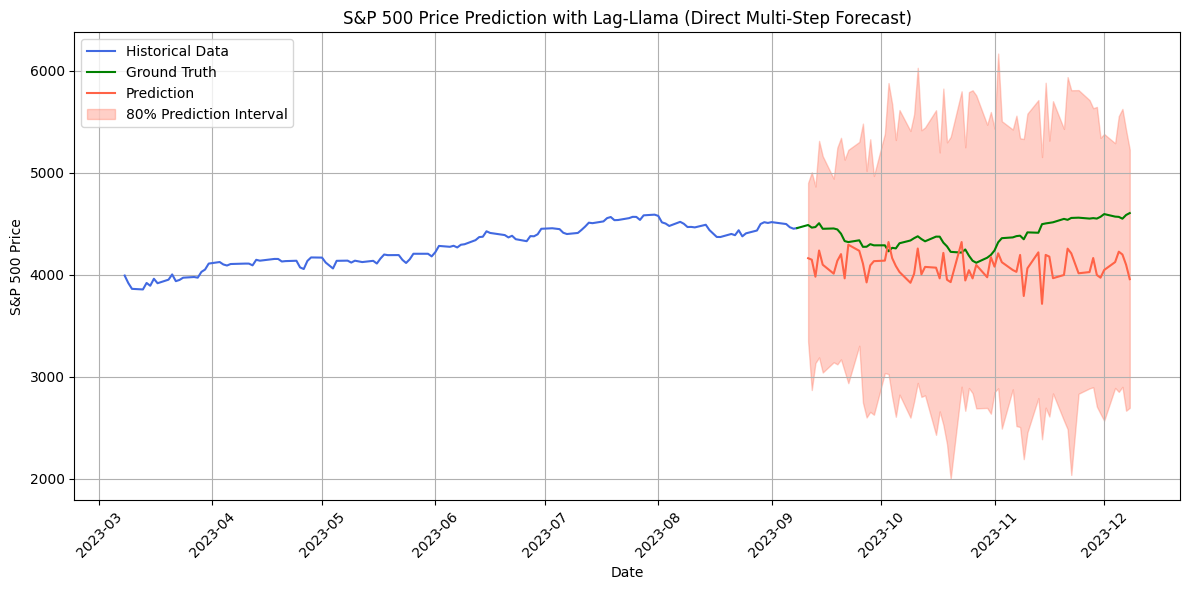

In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions

CONTEXT_WINDOW = 128
FORECAST_STEPS = 64  # Number of one-step forecasts to make

def get_lag_llama_predictions(dataset, prediction_length, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("weights/lag-llama.ckpt", map_location=torch.device("mps" if torch.mps.is_available() else "cpu"))
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
    
    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }
    
    estimator = LagLlamaEstimator(
        ckpt_path="weights/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,
        device=torch.device("mps" if torch.cuda.is_available() else "cpu")
    )
    
    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    
    return forecasts, tss

def generate_single_forecast(context_data, start_date):
    """Generate a single one-step forecast"""
    # Ensure context_data is 1D
    context_data = np.asarray(context_data).flatten()
    
    # Create ListDataset for the current context window
    dataset = ListDataset(
        [{"start": start_date, "target": context_data}],
        freq="D"
    )
    
    # Generate forecast
    forecasts, _ = get_lag_llama_predictions(
        dataset=dataset,
        prediction_length=1,  # One-step forecast
        context_length=CONTEXT_WINDOW,
        use_rope_scaling=True,
        num_samples=100
    )
    
    forecast_samples = forecasts[0].samples
    
    # Extract quantiles
    low, median, high = np.percentile(forecast_samples, [10, 50, 90], axis=0)
    return low[0], median[0], high[0]  # Return single values instead of arrays

def generate_direct_forecast(data, start_idx):
    """Generate multi-step forecast directly"""
    # Get the context window
    context_data = data['Close'].iloc[start_idx - CONTEXT_WINDOW + 1:start_idx + 1].to_numpy().flatten()
    context_start_date = data['Date'].iloc[start_idx - CONTEXT_WINDOW + 1]
    
    # Create ListDataset for the current context window
    dataset = ListDataset(
        [{"start": context_start_date, "target": context_data}],
        freq="D"
    )
    
    # Generate forecast with prediction_length = FORECAST_STEPS
    forecasts, _ = get_lag_llama_predictions(
        dataset=dataset,
        prediction_length=FORECAST_STEPS,  # Now predicting multiple steps at once
        context_length=CONTEXT_WINDOW,
        use_rope_scaling=True,
        num_samples=100
    )
    
    forecast_samples = forecasts[0].samples
    
    # Extract quantiles for all prediction steps at once
    low, median, high = np.percentile(forecast_samples, [10, 50, 90], axis=0)
    
    # Prepare results in the same format as before for compatibility with plotting
    all_forecasts = {
        'median': list(median),
        'low': list(low),
        'high': list(high),
        'dates': [data['Date'].iloc[start_idx + i + 1] for i in range(FORECAST_STEPS)]
    }
    
    return all_forecasts

def plot_forecast_with_sliding_window(data, start_idx, forecasts):
    """Modified plotting function for sliding window forecasts"""
    plt.figure(figsize=(12, 6))
    
    # Plot historical context (last window before forecasts begin)
    context_data = data.iloc[start_idx - CONTEXT_WINDOW + 1:start_idx + 1]
    plt.plot(
        context_data['Date'],
        context_data['Close'],
        color='royalblue',
        label='Historical Data'
    )
    
    # Plot actual prices for forecast period
    actual_data = data.iloc[start_idx :start_idx + FORECAST_STEPS + 1]
    plt.plot(
        actual_data['Date'],
        actual_data['Close'],
        color='green',
        label='Ground Truth'
    )
    
    # Plot forecasts
    forecast_dates = forecasts['dates']
    plt.plot(
        forecast_dates,
        forecasts['median'],
        color='tomato',
        label='Prediction'
    )
    plt.fill_between(
        forecast_dates,
        forecasts['low'],
        forecasts['high'],
        color='tomato',
        alpha=0.3,
        label='80% Prediction Interval'
    )
    
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.title('S&P 500 Price Prediction with Lag-Llama (Direct Multi-Step Forecast)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def calculate_sliding_window_metrics(actual_values, predicted_values):
    """Calculate metrics for sliding window predictions"""
    metrics = calculate_metrics(
        actual_values,
        predicted_values,
        insample=None  # We don't need insample data for sliding window evaluation
    )
    return metrics

# Main execution
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]
sp500_d["Date"] = pd.to_datetime(sp500_d["Date"])

# Select start index for forecasting (e.g., for 2021-09-09)
target_date = pd.Timestamp('2023-09-09')
start_idx = sp500_d[sp500_d['Date'] <= target_date].index[-1]

# Generate forecasts using direct multi-step approach
forecasts = generate_direct_forecast(sp500_d, start_idx)

# Calculate metrics
actual_values = sp500_d['Close'].iloc[start_idx + 1:start_idx + FORECAST_STEPS + 1].values
metrics = calculate_sliding_window_metrics(actual_values, forecasts['median'])

# Print metrics
print("\nSliding Window Forecast Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot results
plot_forecast_with_sliding_window(sp500_d, start_idx, forecasts)

In [128]:
pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.5 MB/s eta 0:00:00
  Using cached tokenizers-0.21.0-cp39-abi3-macosx_11_0_arm64.whl.metadata (6.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 7.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 7.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.9/408.9 kB 7.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 8.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.8/284.8 kB 7.6 MB/s eta 0:00:00
Using cached tokenizers-0.21.0-cp39-abi3-macosx_11_0_arm64.whl (2.6 MB)

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_56224/948748513.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(
/Users/anthonybolton/Devel


Approach A (Iterative Single-Step) Metrics (16-day horizon):
MAE: 0.0551
MSE: 0.0039
RMSE: 0.0626
MAPE: 5.5435
SMAPE: 5.7504
MASE: 8.6408


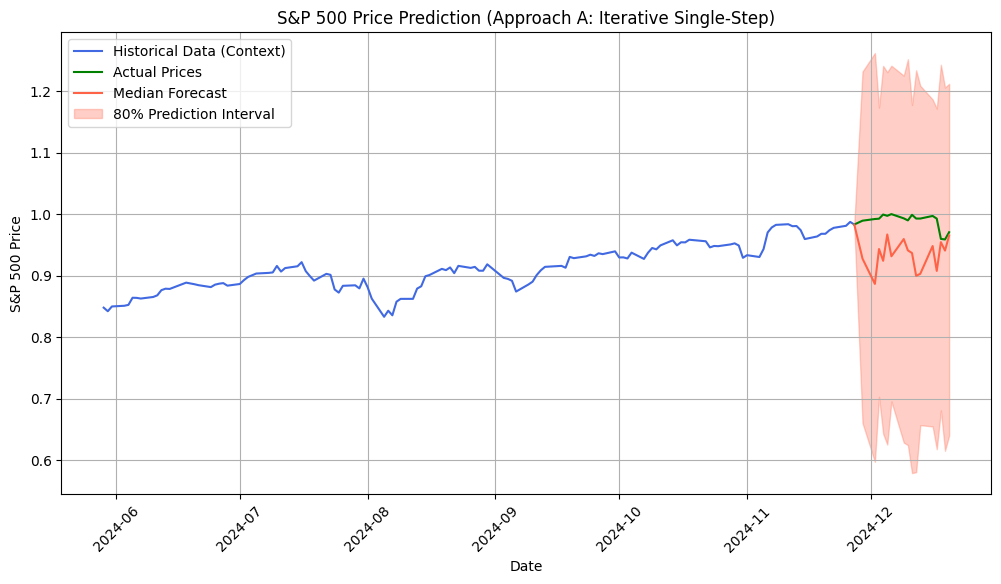

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator

from data_snp.snp500 import snp500_daily
from utils_snp.metrics import metric

# -----------------------------
# HYPERPARAMETERS
# -----------------------------
CONTEXT_WINDOW = 128
HORIZON = 16  # We want to forecast 16 days in total (one day at a time)

# -----------------------------
# MODEL LOADING + FORECAST UTIL
# -----------------------------
def get_lag_llama_predictions(dataset, prediction_length, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load(
        "weights/lag-llama.ckpt",
        map_location=torch.device("mps" if torch.cuda.is_available() else "cpu")
    )
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
    
    # Adjust the rope scaling factor for the new context + prediction length
    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }
    
    estimator = LagLlamaEstimator(
        ckpt_path="weights/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,
        device=torch.device("mps" if torch.cuda.is_available() else "cpu")
    )
    
    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    
    return forecasts, tss

def generate_one_day_forecast(context_data, dates):
    """
    Generate a *single-step* (prediction_length=1) forecast using Lag-Llama.
    Returns low, median, high for that single predicted day.
    """
    # Ensure data is 1D and dates are correct
    context = np.asarray(context_data).flatten()
    start_date = dates.iloc[0]

    # Create ListDataset with freq="D"
    dataset = ListDataset(
        [{"start": start_date, "target": context}],
        freq="D"
    )
    
    # Generate SINGLE-DAY forecast
    forecasts, _ = get_lag_llama_predictions(
        dataset=dataset,
        prediction_length=1,           # <--- single-step
        context_length=CONTEXT_WINDOW, # still 32
        use_rope_scaling=True,
        num_samples=100
    )
    forecast_samples = forecasts[0].samples  # shape: (num_samples, 1)

    # Extract quantiles (just 1 point, so each is shape (1,))
    low, median, high = np.percentile(forecast_samples, [10, 50, 90], axis=0)
    return low[0], median[0], high[0]

# -----------------------------
# METRICS + PLOTTING
# -----------------------------
def calculate_metrics(actual, predicted, insample=None):
    """Calculate all metrics using the metrics.py implementations"""
    actual = np.array(actual).flatten()
    predicted = np.array(predicted).flatten()

    mae, mse, rmse, mape, mspe = metric(predicted, actual)

    smape = 200 * np.mean(
        np.abs(predicted - actual) / (np.abs(predicted) + np.abs(actual))
    )

    if insample is not None:
        naive_forecast = insample[:-1]
        naive_target = insample[1:]
        naive_mae = np.mean(np.abs(naive_target - naive_forecast))
        mase = mae / naive_mae if naive_mae != 0 else np.nan
    else:
        mase = np.nan

    metrics = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape * 100,
        "SMAPE": smape,
        "MASE": mase if not np.isnan(mase) else None,
    }
    return metrics

def plot_forecast(
    data,
    context_window,
    prediction_window,
    median_forecast,
    low_forecast,
    high_forecast,
    title,
):
    """Create visualization with zoomed context"""
    plt.figure(figsize=(12, 6))

    # Get the last point of historical context
    last_context_point = data["NormalizedPriceMinMax"].iloc[-prediction_window - 1]

    # Add last context point to forecasts for continuity
    median_forecast = np.insert(median_forecast, 0, last_context_point)
    low_forecast = np.insert(low_forecast, 0, last_context_point)
    high_forecast = np.insert(high_forecast, 0, last_context_point)

    # Create forecast dates
    forecast_dates = pd.concat(
        [
            data["Date"].iloc[-(prediction_window + 1) : -prediction_window],
            data["Date"].iloc[-prediction_window:],
        ]
    )

    # Get actual prices including last context point
    actual_prices = data["NormalizedPriceMinMax"].iloc[-prediction_window:].values
    actual_prices = np.insert(actual_prices, 0, last_context_point)

    # Plot historical context
    plt.plot(
        data["Date"].iloc[-(context_window + prediction_window) : -prediction_window],
        data["NormalizedPriceMinMax"].iloc[-(context_window + prediction_window) : -prediction_window],
        color="royalblue",
        label="Historical Data (Context)",
    )

    # Plot actual prices
    plt.plot(forecast_dates, actual_prices, color="green", label="Actual Prices")

    # Plot forecast
    plt.plot(forecast_dates, median_forecast, color="tomato", label="Median Forecast")
    plt.fill_between(
        forecast_dates,
        low_forecast,
        high_forecast,
        color="tomato",
        alpha=0.3,
        label="80% Prediction Interval",
    )

    plt.xlabel("Date")
    plt.ylabel("S&P 500 Price")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.show()

# ------------------------------------------------------------------------------
# MAIN SCRIPT — Implement "Approach A" (Iterative Single-Step) for a 16-Day horizon
# ------------------------------------------------------------------------------
# Load data
sp500_d = snp500_daily.reset_index()[["Date", "NormalizedPriceMinMax"]]
sp500_d["Date"] = pd.to_datetime(sp500_d["Date"])

# 1) Prepare the initial context of length CONTEXT_WINDOW
#    We'll say the last known day in your dataset is T,
#    so the context covers days T-31 to T.
context_data = sp500_d["NormalizedPriceMinMax"].values[-CONTEXT_WINDOW:].copy()
context_dates = sp500_d["Date"].iloc[-CONTEXT_WINDOW:].copy()

# 2) We'll forecast 16 days in an iterative manner
horizon_low = []
horizon_med = []
horizon_high = []

for step in range(HORIZON):
    # Forecast 1 day ahead using current context
    low_pred, med_pred, high_pred = generate_one_day_forecast(context_data, context_dates)

    # Collect these predictions
    horizon_low.append(low_pred)
    horizon_med.append(med_pred)
    horizon_high.append(high_pred)

    # 3) "Append" the predicted day to the context as if it were real data
    #    Remove the oldest day, shift the context by 1, and add the new predicted point
    context_data = np.append(context_data[1:], med_pred)  # feed the median prediction
    last_date_in_context = context_dates.iloc[-1]
    next_date = last_date_in_context + pd.Timedelta(days=1)
    context_dates = pd.concat([context_dates.iloc[1:], pd.Series([next_date])], ignore_index=True)

# 4) Evaluate metrics against the actual next 16 days in your dataset
#    The actual next 16 days are the final 16 values of 'Close' in sp500_d
actual_future = sp500_d["NormalizedPriceMinMax"].values[-HORIZON:]
insample_data = sp500_d["NormalizedPriceMinMax"].values[-(CONTEXT_WINDOW + HORIZON) : -HORIZON]

metrics_res = calculate_metrics(actual_future, horizon_med, insample=insample_data)
print("\nApproach A (Iterative Single-Step) Metrics (16-day horizon):")
for k, v in metrics_res.items():
    if v is not None:
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: N/A")

# 5) Plot
#    We'll reuse the original plot function, but we need arrays for median, low, high
#    that line up with the last 16 days in the dataset.
#    horizon_med, horizon_low, horizon_high are length 16.
plot_forecast(
    data=sp500_d,
    context_window=CONTEXT_WINDOW,
    prediction_window=HORIZON,
    median_forecast=horizon_med,
    low_forecast=horizon_low,
    high_forecast=horizon_high,
    title="S&P 500 Price Prediction (Approach A: Iterative Single-Step)"
)


/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_56224/2199004424.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(
/Users/anthonybolton/Deve


Approach B + MinMax Normalization (Rolling-Origin, Single-Step) Metrics:
MAE: 180.6513
MSE: 42894.8121
RMSE: 207.1106
MAPE: 3.0167
SMAPE: 3.0268
MASE: 5.8491


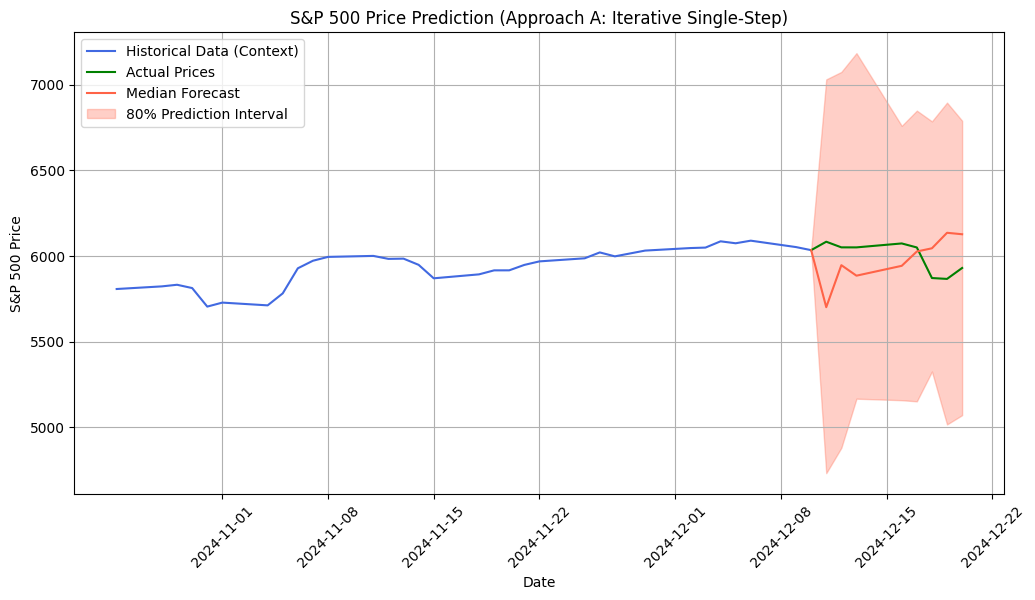

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator

from data_snp.snp500 import snp500_daily
from utils_snp.metrics import metric
from utils_snp.normalizer import Normalizer

# -----------------------------
# HYPERPARAMETERS
# -----------------------------
CONTEXT_WINDOW = 32
HORIZON = 8  # We'll produce forecasts for 16 consecutive days (each day individually)

# -----------------------------
# MODEL LOADING + FORECAST UTIL
# -----------------------------
def get_lag_llama_predictions(dataset, prediction_length, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load(
        "weights/lag-llama.ckpt",
        map_location=torch.device("mps" if torch.cuda.is_available() else "cpu")
    )
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
    
    # Adjust rope scaling for the new context + prediction length
    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }
    
    estimator = LagLlamaEstimator(
        ckpt_path="weights/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,
        device=torch.device("mps" if torch.cuda.is_available() else "cpu")
    )
    
    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    
    return forecasts, tss

def generate_one_day_forecast(context_data, dates):
    """
    Generate a *single-step* (prediction_length=1) forecast using Lag-Llama.
    Returns low, median, high for that single predicted day.
    """
    context = np.asarray(context_data).flatten()
    start_date = dates.iloc[0]

    # Create ListDataset
    dataset = ListDataset(
        [{"start": start_date, "target": context}],
        freq="D"
    )
    
    # Single-day forecast call
    forecasts, _ = get_lag_llama_predictions(
        dataset=dataset,
        prediction_length=1,           # Single-step
        context_length=CONTEXT_WINDOW,
        use_rope_scaling=True,
        num_samples=100
    )
    forecast_samples = forecasts[0].samples  # shape: (num_samples, 1)

    # Extract quantiles (1 day => each is shape (1,))
    low, median, high = np.percentile(forecast_samples, [10, 50, 90], axis=0)
    return low[0], median[0], high[0]

# -----------------------------
# METRICS + PLOTTING
# -----------------------------
def calculate_metrics(actual, predicted, insample=None):
    """Calculate all metrics using the metrics.py implementations"""
    actual = np.array(actual).flatten()
    predicted = np.array(predicted).flatten()

    mae, mse, rmse, mape, mspe = metric(predicted, actual)

    smape = 200 * np.mean(
        np.abs(predicted - actual) / (np.abs(predicted) + np.abs(actual))
    )

    if insample is not None:
        naive_forecast = insample[:-1]
        naive_target = insample[1:]
        naive_mae = np.mean(np.abs(naive_target - naive_forecast))
        mase = mae / naive_mae if naive_mae != 0 else np.nan
    else:
        mase = np.nan

    metrics = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape * 100,
        "SMAPE": smape,
        "MASE": mase if not np.isnan(mase) else None,
    }
    return metrics

def plot_forecast(
    data,
    context_window,
    prediction_window,
    median_forecast,
    low_forecast,
    high_forecast,
    title,
):
    """Create visualization with zoomed context"""
    plt.figure(figsize=(12, 6))

    # Get the last point of historical context
    last_context_point = data["Close"].iloc[-prediction_window - 1]

    # Add last context point to forecasts for continuity
    median_forecast = np.insert(median_forecast, 0, last_context_point)
    low_forecast = np.insert(low_forecast, 0, last_context_point)
    high_forecast = np.insert(high_forecast, 0, last_context_point)

    # Create forecast dates
    forecast_dates = pd.concat(
        [
            data["Date"].iloc[-(prediction_window + 1) : -prediction_window],
            data["Date"].iloc[-prediction_window:],
        ]
    )

    # Get actual prices including last context point
    actual_prices = data["Close"].iloc[-prediction_window:].values
    actual_prices = np.insert(actual_prices, 0, last_context_point)

    # Plot historical context
    plt.plot(
        data["Date"].iloc[-(context_window + prediction_window) : -prediction_window],
        data["Close"].iloc[-(context_window + prediction_window) : -prediction_window],
        color="royalblue",
        label="Historical Data (Context)",
    )

    # Plot actual prices
    plt.plot(forecast_dates, actual_prices, color="green", label="Actual Prices")

    # Plot forecast
    plt.plot(forecast_dates, median_forecast, color="tomato", label="Median Forecast")
    plt.fill_between(
        forecast_dates,
        low_forecast,
        high_forecast,
        color="tomato",
        alpha=0.3,
        label="80% Prediction Interval",
    )

    plt.xlabel("Date")
    plt.ylabel("S&P 500 Price")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.show()

# 1) Load original data
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]
sp500_d["Date"] = pd.to_datetime(sp500_d["Date"])
sp500_d.sort_values("Date", inplace=True, ignore_index=True)

# 2) Instantiate our Normalizer for min-max scaling
normalizer = Normalizer(norm_type="minmax")

# 3) Add a "Close_norm" column to sp500_d by normalizing the entire time series
#    We'll pass a DataFrame subset to .normalize()
sp500_d["Close_norm"] = normalizer.normalize(sp500_d[["Close"]])

# For a rolling-origin single-step forecast (HORIZON days):
full_length = len(sp500_d)
T = full_length - HORIZON - 1

horizon_low = []
horizon_med = []
horizon_high = []

# We'll collect the *denormalized* predictions
for step in range(HORIZON):
    # The day to forecast is T + step + 1
    # Our context is the last CONTEXT_WINDOW real data points in *normalized* scale
    start_idx = (T + step) - (CONTEXT_WINDOW - 1)
    end_idx   = T + step

    # context_data = normalized close values only
    context_data = sp500_d["Close_norm"].values[start_idx : end_idx + 1]
    context_dates = sp500_d["Date"].iloc[start_idx : end_idx + 1]

    # forecast_samples are in *normalized* scale
    forecast_samples_norm = generate_one_day_forecast(context_data, context_dates)

    # Denormalize the forecast samples
    # The Normalizer's denormalize() expects a DataFrame or array
    forecast_samples_df = pd.DataFrame(forecast_samples_norm)  # shape: (num_samples, 1)
    forecast_samples_denorm = normalizer.denormalize(forecast_samples_df).values  # shape: (num_samples, 1)

    # Extract quantiles in real (denormalized) scale
    low_q, med_q, high_q = np.percentile(forecast_samples_denorm, [10, 50, 90], axis=0)
    horizon_low.append(low_q)
    horizon_med.append(med_q)
    horizon_high.append(high_q)

# Compare forecasts with actual final HORIZON days in real scale
actual_future = sp500_d["Close"].values[-HORIZON:]
# insample data for MASE
insample_data = sp500_d["Close"].values[-(CONTEXT_WINDOW + HORIZON) : -HORIZON]

# Evaluate metrics
metrics_res = calculate_metrics(actual_future, horizon_med, insample=insample_data)
print("\nApproach B + MinMax Normalization (Rolling-Origin, Single-Step) Metrics:")
for k, v in metrics_res.items():
    if v is not None:
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: N/A")

# Plot final results
# We'll reuse the 'plot_forecast' but pass relevant arrays
# The plot_forecast function expects a single Series/array for actual,
# so we pass sp500_d as is, and also pass the forecast arrays.
plot_forecast(
    data=sp500_d,
    context_window=CONTEXT_WINDOW,
    prediction_window=HORIZON,
    median_forecast=horizon_med,
    low_forecast=horizon_low,
    high_forecast=horizon_high,
    title="S&P 500 Price Prediction (Approach A: Iterative Single-Step)"
)

# COVID-19 recovery

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60207/3907734629.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 


COVID Period Metrics:
MAE: 945.3959
MSE: 923046.9130
RMSE: 960.7533
MAPE: 20.6858
SMAPE: 23.1447
MASE: 26.8703


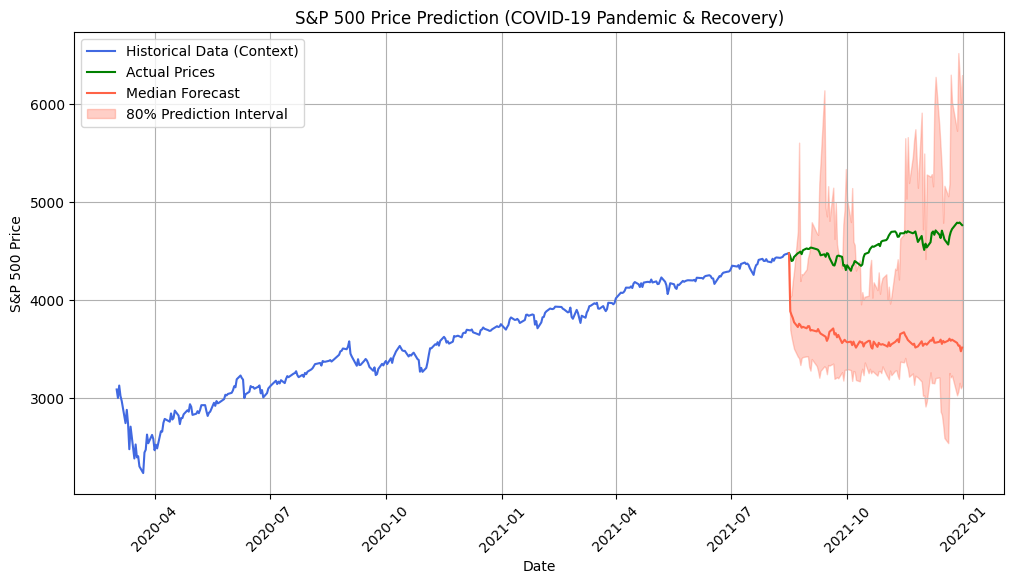

In [26]:
# COVID-19 Period Analysis
covid_start_date = "2020-03-01"
covid_end_date = "2021-12-31"

# Filter COVID period data
covid_data = sp500_d[
    (sp500_d["Date"] >= covid_start_date) & (sp500_d["Date"] <= covid_end_date)
].reset_index(drop=True)

# Generate COVID period forecast
covid_context = (
    covid_data["Close"]
    .iloc[-(CONTEXT_WINDOW + PREDICTION_WINDOW) : -PREDICTION_WINDOW]
    .values
)

# Get corresponding dates for the context period
covid_context_dates = covid_data["Date"].iloc[
    -(CONTEXT_WINDOW + PREDICTION_WINDOW) : -PREDICTION_WINDOW
]

# Generate forecast for the COVID period
low_covid, median_covid, high_covid = generate_forecast(covid_context, covid_context_dates)

# Calculate and print COVID period metrics
actual_prices_covid = covid_data["Close"].iloc[-PREDICTION_WINDOW:].values
insample_data_covid = (
    covid_data["Close"]
    .iloc[-CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW]
    .values
)
metrics_covid = calculate_metrics(
    actual_prices_covid, median_covid, insample=insample_data_covid
)

print("\nCOVID Period Metrics:")
for metric_name, value in metrics_covid.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot COVID period forecast
plot_forecast(
    covid_data,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median_covid,
    low_covid,
    high_covid,
    "S&P 500 Price Prediction (COVID-19 Pandemic & Recovery)",
)


# Experimenting with different context and prediction windows for different frequencies: daily, weekly, monthly. Note that for lag-llama conetxt window must be > prediction window


Running daily frequency experiments...


/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60875/3924528634.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

Skipping invalid combination: context_window=96, prediction_window=192
Skipping invalid combination: context_window=96, prediction_window=336
Skipping invalid combination: context_window=96, prediction_window=720


/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60875/3924528634.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

Skipping invalid combination: context_window=192, prediction_window=336
Skipping invalid combination: context_window=192, prediction_window=720


/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60875/3924528634.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

Skipping invalid combination: context_window=336, prediction_window=720


/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60875/3924528634.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

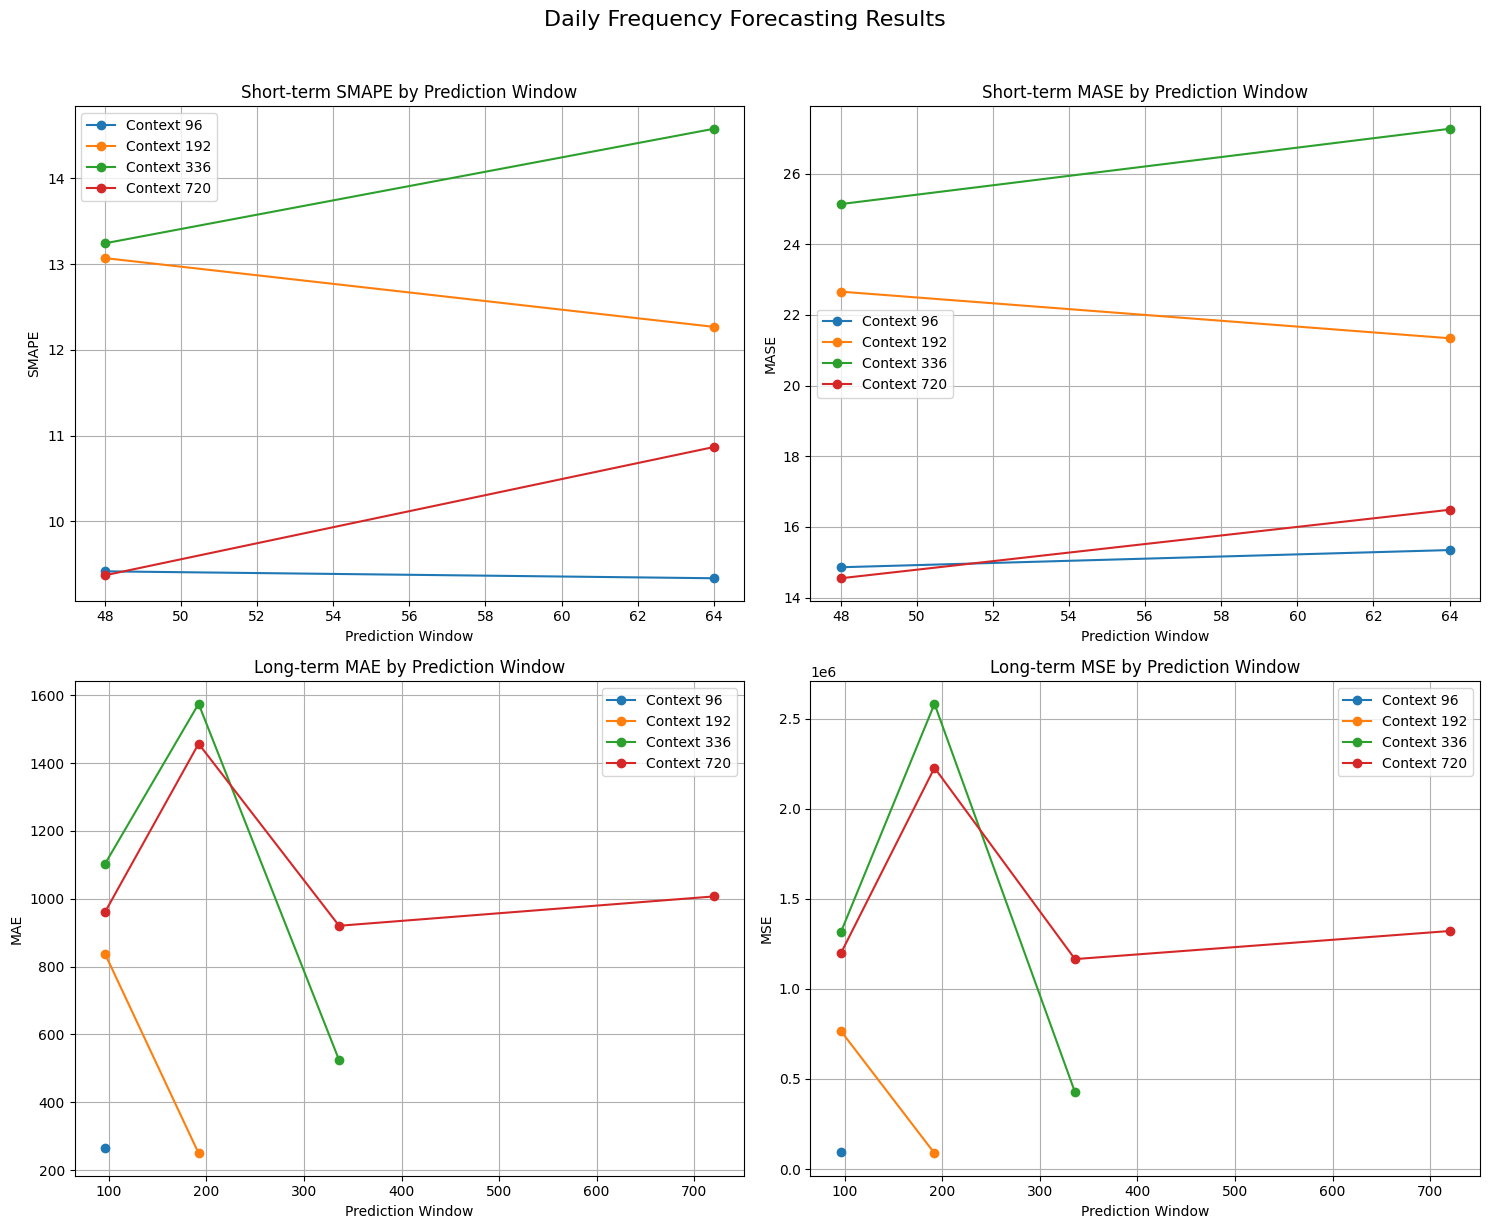


Daily Frequency Results:

Short-term Forecasting Results:
Metric                                 MAE     MAPE     MASE          MSE  \
Context Window Prediction Window                                            
96             48                 534.1976   8.9827  14.8591  294581.6174   
               64                 526.2075   8.8990  15.3455  293857.1755   
192            48                 728.3981  12.2428  22.6608  551564.8210   
               64                 680.8361  11.5022  21.3418  507184.3786   
336            48                 737.1031  12.3854  25.1398  570883.6465   
               64                 798.1068  13.4768  27.2704  717679.4010   
720            48                 530.9030   8.9019  14.5477  318595.4532   
               64                 603.4977  10.1520  16.4861  473847.1046   

Metric                                RMSE    SMAPE  
Context Window Prediction Window                     
96             48                 542.7537   9.4177  
        

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60875/3924528634.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

Skipping invalid combination: context_window=24, prediction_window=48
Skipping invalid combination: context_window=24, prediction_window=64
Skipping invalid combination: context_window=24, prediction_window=96


/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60875/3924528634.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

Skipping invalid combination: context_window=48, prediction_window=64
Skipping invalid combination: context_window=48, prediction_window=96


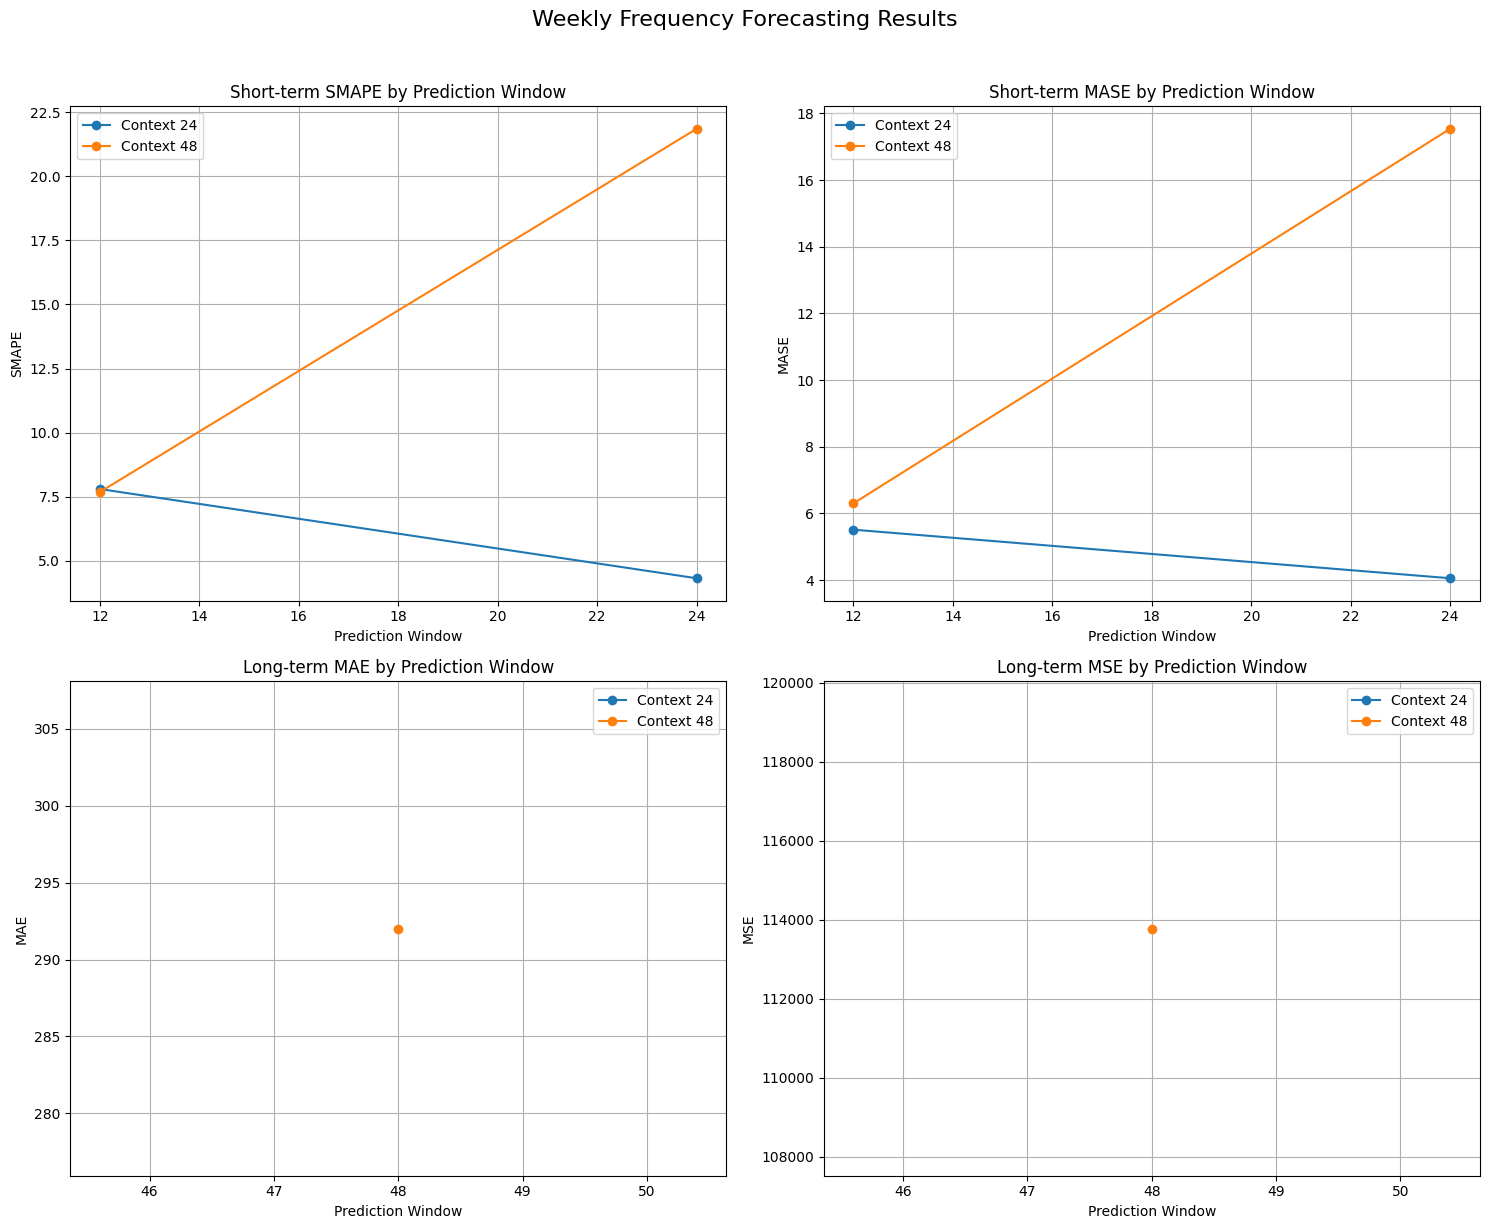


Weekly Frequency Results:

Short-term Forecasting Results:
Metric                                  MAE     MAPE     MASE           MSE  \
Context Window Prediction Window                                              
24             12                  444.6512   7.4820   5.5103  2.175420e+05   
               24                  245.8746   4.2081   4.0532  8.575151e+04   
48             12                  437.8516   7.3554   6.3003  2.239690e+05   
               24                 1131.3938  19.5831  17.5366  1.370134e+06   

Metric                                 RMSE    SMAPE  
Context Window Prediction Window                      
24             12                  466.4140   7.8009  
               24                  292.8336   4.3213  
48             12                  473.2536   7.6835  
               24                 1170.5272  21.8503  

Long-term Forecasting Results:
Metric                                 MAE    MAPE    MASE          MSE  \
Context Window Prediction Wi

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60875/3924528634.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

Skipping invalid combination: context_window=6, prediction_window=12
Skipping invalid combination: context_window=6, prediction_window=24


/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60875/3924528634.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

Skipping invalid combination: context_window=12, prediction_window=24


/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60875/3924528634.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

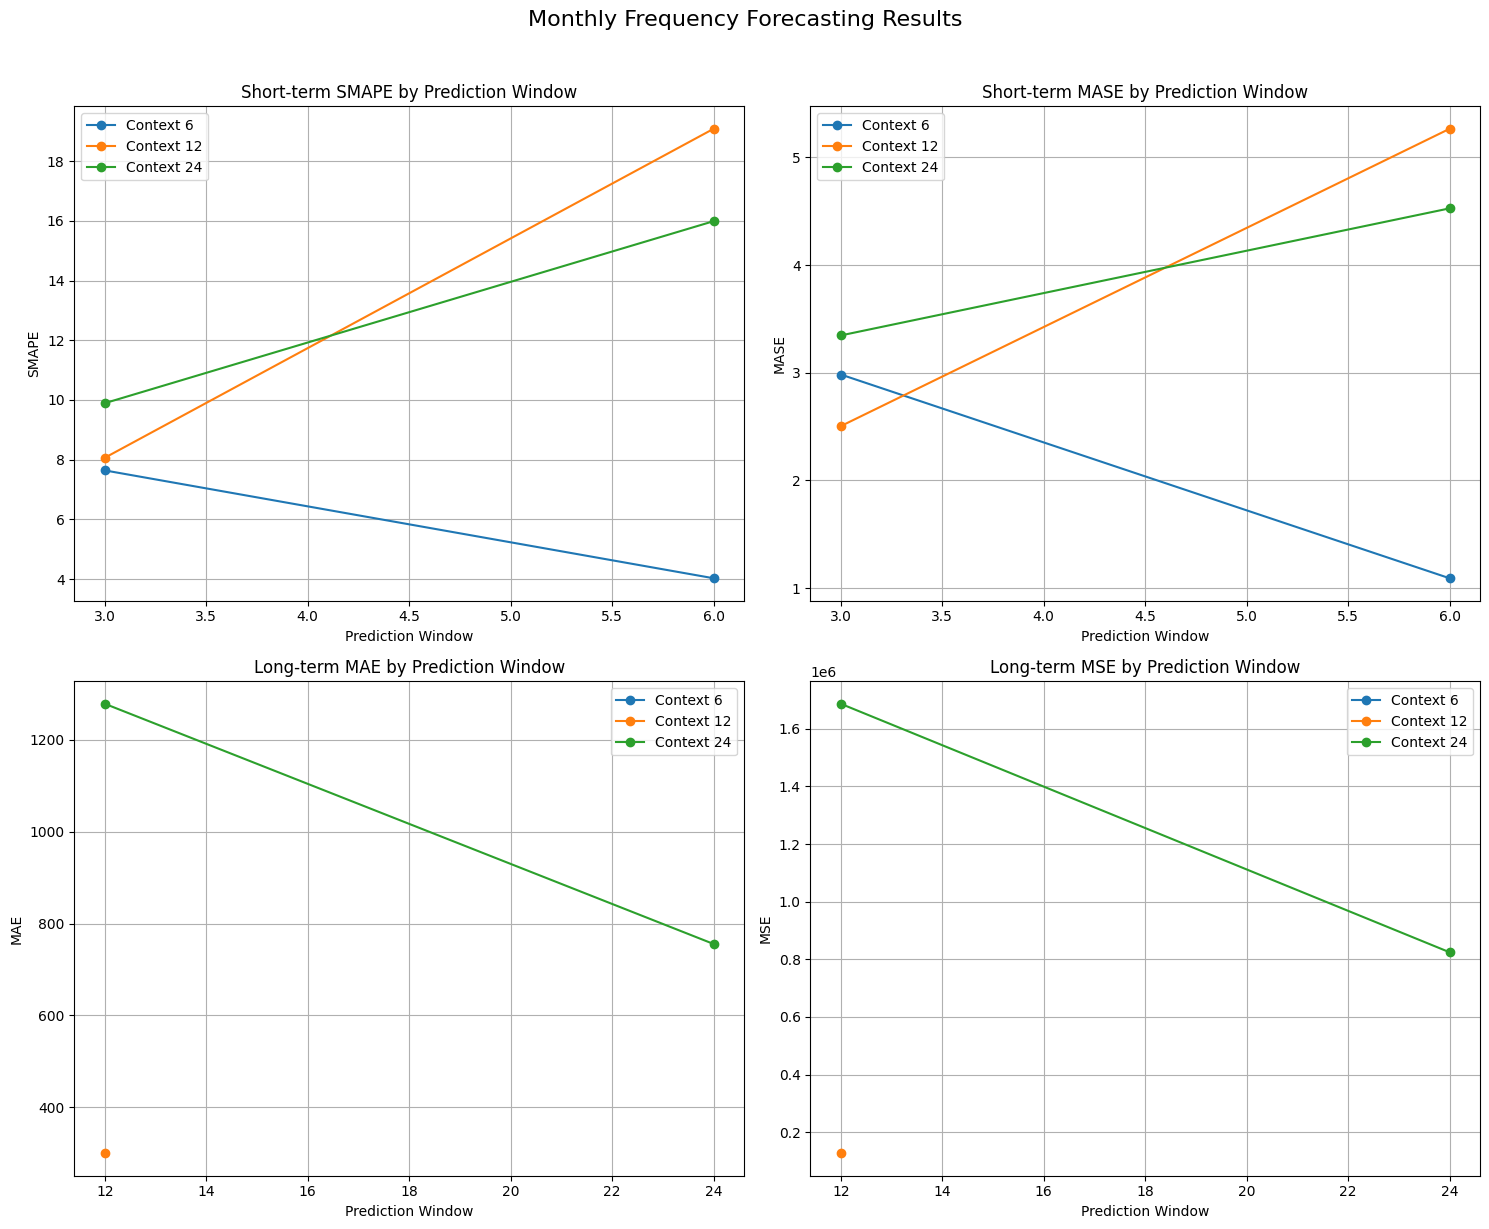


Monthly Frequency Results:

Short-term Forecasting Results:
Metric                                  MAE     MAPE    MASE           MSE  \
Context Window Prediction Window                                             
6              3                   433.6736   7.3346  2.9835  2.068700e+05   
               6                   229.6953   3.9140  1.0916  7.803343e+04   
12             3                   456.7298   7.7241  2.5045  2.300067e+05   
               6                  1004.8255  17.3941  5.2655  1.031934e+06   
24             3                   554.7057   9.3879  3.3466  3.363069e+05   
               6                   854.4048  14.7791  4.5266  7.512259e+05   

Metric                                 RMSE    SMAPE  
Context Window Prediction Window                      
6              3                   454.8296   7.6402  
               6                   279.3446   4.0288  
12             3                   479.5901   8.0649  
               6                  1015.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator

from data.snp500 import snp500_daily, snp500_monthly, snp500_weekly
from utils.evaluate import ContextPredictionWindowEvaluator


def lag_llama_forecast(model, context, prediction_window, freq="D"):
    """Forecast function for Lag-Llama model"""
    # Ensure data is 1D
    context = np.asarray(context).flatten()

    # Validate context length
    if len(context) < prediction_window:
        raise ValueError(
            f"Context length ({len(context)}) is less than the prediction window ({prediction_window})."
        )

    # Create a pandas Series with datetime index
    dates = pd.date_range(end=pd.Timestamp.now(), periods=len(context), freq=freq)
    context_series = pd.Series(context, index=dates)

    # Load the checkpoint
    ckpt = torch.load("weights/lag-llama.ckpt", map_location=torch.device("mps"))
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    # Initialize the model
    estimator = LagLlamaEstimator(
        ckpt_path="weights/lag-llama.ckpt",
        prediction_length=prediction_window,
        context_length=len(context),
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (len(context) + prediction_window) / estimator_args["context_length"]),
        },
        device=torch.device("mps"),
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    # Prepare data in GluonTS format
    dataset = ListDataset(
        [{"start": str(dates[0]), "target": context}],
        freq=freq,
    )

    # Generate forecast
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset, predictor=predictor, num_samples=100
    )
    forecasts = list(forecast_it)
    forecast_samples = forecasts[0].samples

    # Extract quantiles and ensure correct length
    low, median, high = np.percentile(forecast_samples, [10, 50, 90], axis=0)

    # Verify lengths match expected prediction window
    assert (
        len(median) == prediction_window
    ), f"Prediction length mismatch: got {len(median)}, expected {prediction_window}"

    return low, median, high

# Plot results by frequency
def plot_results_by_frequency(results_df, frequency):
    """Create plots for short-term and long-term metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(
        f"{frequency.capitalize()} Frequency Forecasting Results", fontsize=16, y=1.02
    )

    # Short-term metrics (SMAPE and MASE)
    short_term = results_df[results_df["Horizon"] == "short_term"]
    context_windows = sorted(short_term["Context Window"].unique())

    # Plot SMAPE
    ax = axes[0, 0]
    for context in context_windows:
        data = short_term[
            (short_term["Context Window"] == context)
            & (short_term["Metric"] == "SMAPE")
        ]
        ax.plot(
            data["Prediction Window"],
            data["Value"],
            marker="o",
            label=f"Context {context}",
        )
    ax.set_xlabel("Prediction Window")
    ax.set_ylabel("SMAPE")
    ax.set_title("Short-term SMAPE by Prediction Window")
    ax.grid(True)
    ax.legend()

    # Plot MASE
    ax = axes[0, 1]
    for context in context_windows:
        data = short_term[
            (short_term["Context Window"] == context) & (short_term["Metric"] == "MASE")
        ]
        ax.plot(
            data["Prediction Window"],
            data["Value"],
            marker="o",
            label=f"Context {context}",
        )
    ax.set_xlabel("Prediction Window")
    ax.set_ylabel("MASE")
    ax.set_title("Short-term MASE by Prediction Window")
    ax.grid(True)
    ax.legend()

    # Long-term metrics (MAE and MSE)
    long_term = results_df[results_df["Horizon"] == "long_term"]

    # Plot MAE
    ax = axes[1, 0]
    for context in context_windows:
        data = long_term[
            (long_term["Context Window"] == context) & (long_term["Metric"] == "MAE")
        ]
        ax.plot(
            data["Prediction Window"],
            data["Value"],
            marker="o",
            label=f"Context {context}",
        )
    ax.set_xlabel("Prediction Window")
    ax.set_ylabel("MAE")
    ax.set_title("Long-term MAE by Prediction Window")
    ax.grid(True)
    ax.legend()

    # Plot MSE
    ax = axes[1, 1]
    for context in context_windows:
        data = long_term[
            (long_term["Context Window"] == context) & (long_term["Metric"] == "MSE")
        ]
        ax.plot(
            data["Prediction Window"],
            data["Value"],
            marker="o",
            label=f"Context {context}",
        )
    ax.set_xlabel("Prediction Window")
    ax.set_ylabel("MSE")
    ax.set_title("Long-term MSE by Prediction Window")
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    plt.show()

# Initialize experiment runner with dummy model (will be recreated for each prediction)
dummy_model = None  # Model will be created dynamically in lag_llama_forecast

experiments = ContextPredictionWindowEvaluator(
    model=dummy_model, forecast_fn=lag_llama_forecast
)

# Dictionary to store results for each frequency
frequency_results = {}

# Run experiments for each frequency
frequency_results = {}

# Run experiments for each frequency
frequencies = {
    "daily": ("D", snp500_daily),
    "weekly": ("W", snp500_weekly),
    "monthly": ("M", snp500_monthly),
}

for freq_name, (freq, data) in frequencies.items():
    print(f"\nRunning {freq_name} frequency experiments...")

    # Update the forecast function to include frequency
    experiments.forecast_fn = lambda model, context, pred_window: lag_llama_forecast(
        model, context, pred_window, freq=freq
    )

    # Run experiments
    results = experiments.run_frequency_experiments_context_cannot_be_snaller_than_prediction(data, freq_name)
    frequency_results[freq_name] = results

    # Format results
    df_results = experiments.format_results(results)

    # Create visualizations
    plot_results_by_frequency(df_results, freq_name)

    # Create separate DataFrames for short-term and long-term results
    short_term_df = (
        df_results[df_results["Horizon"] == "short_term"]
        .pivot_table(
            index=["Context Window", "Prediction Window"],
            columns="Metric",
            values="Value",
        )
        .round(4)
    )

    long_term_df = (
        df_results[df_results["Horizon"] == "long_term"]
        .pivot_table(
            index=["Context Window", "Prediction Window"],
            columns="Metric",
            values="Value",
        )
        .round(4)
    )

    print(f"\n{freq_name.capitalize()} Frequency Results:")
    print("\nShort-term Forecasting Results:")
    print(short_term_df)
    print("\nLong-term Forecasting Results:")
    print(long_term_df)



# Forecasting visuals and metric results of best performing runs for recent and COVID-19 periods

Generating plots for extended period...


/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60875/1019413267.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

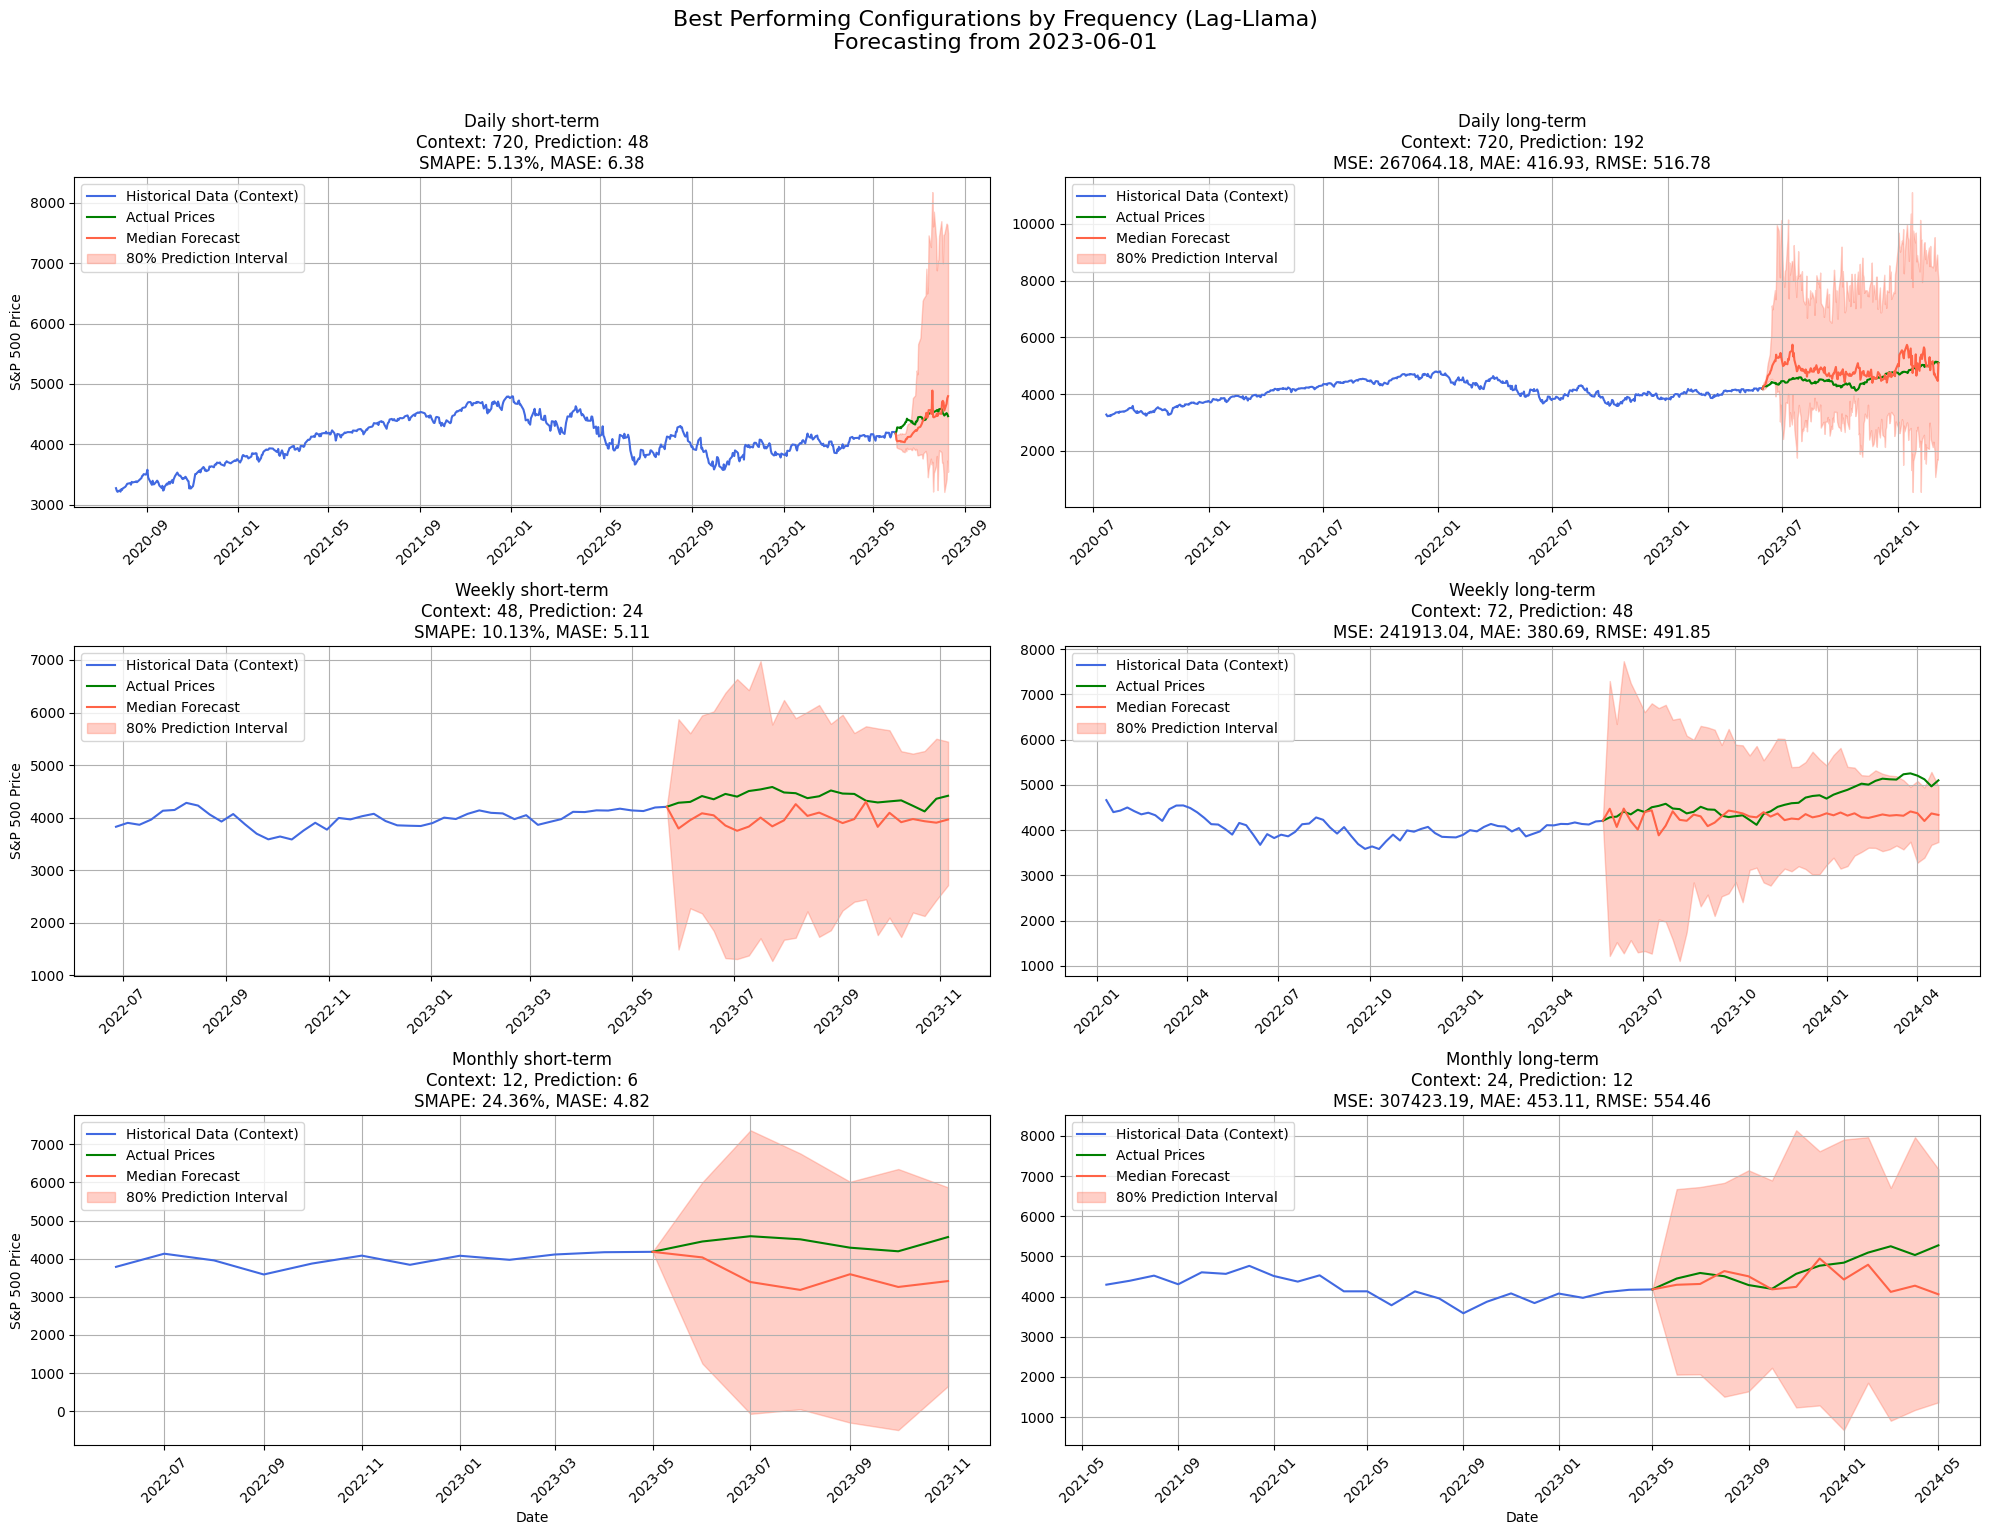


Generating plots for COVID period...


/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60875/1019413267.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

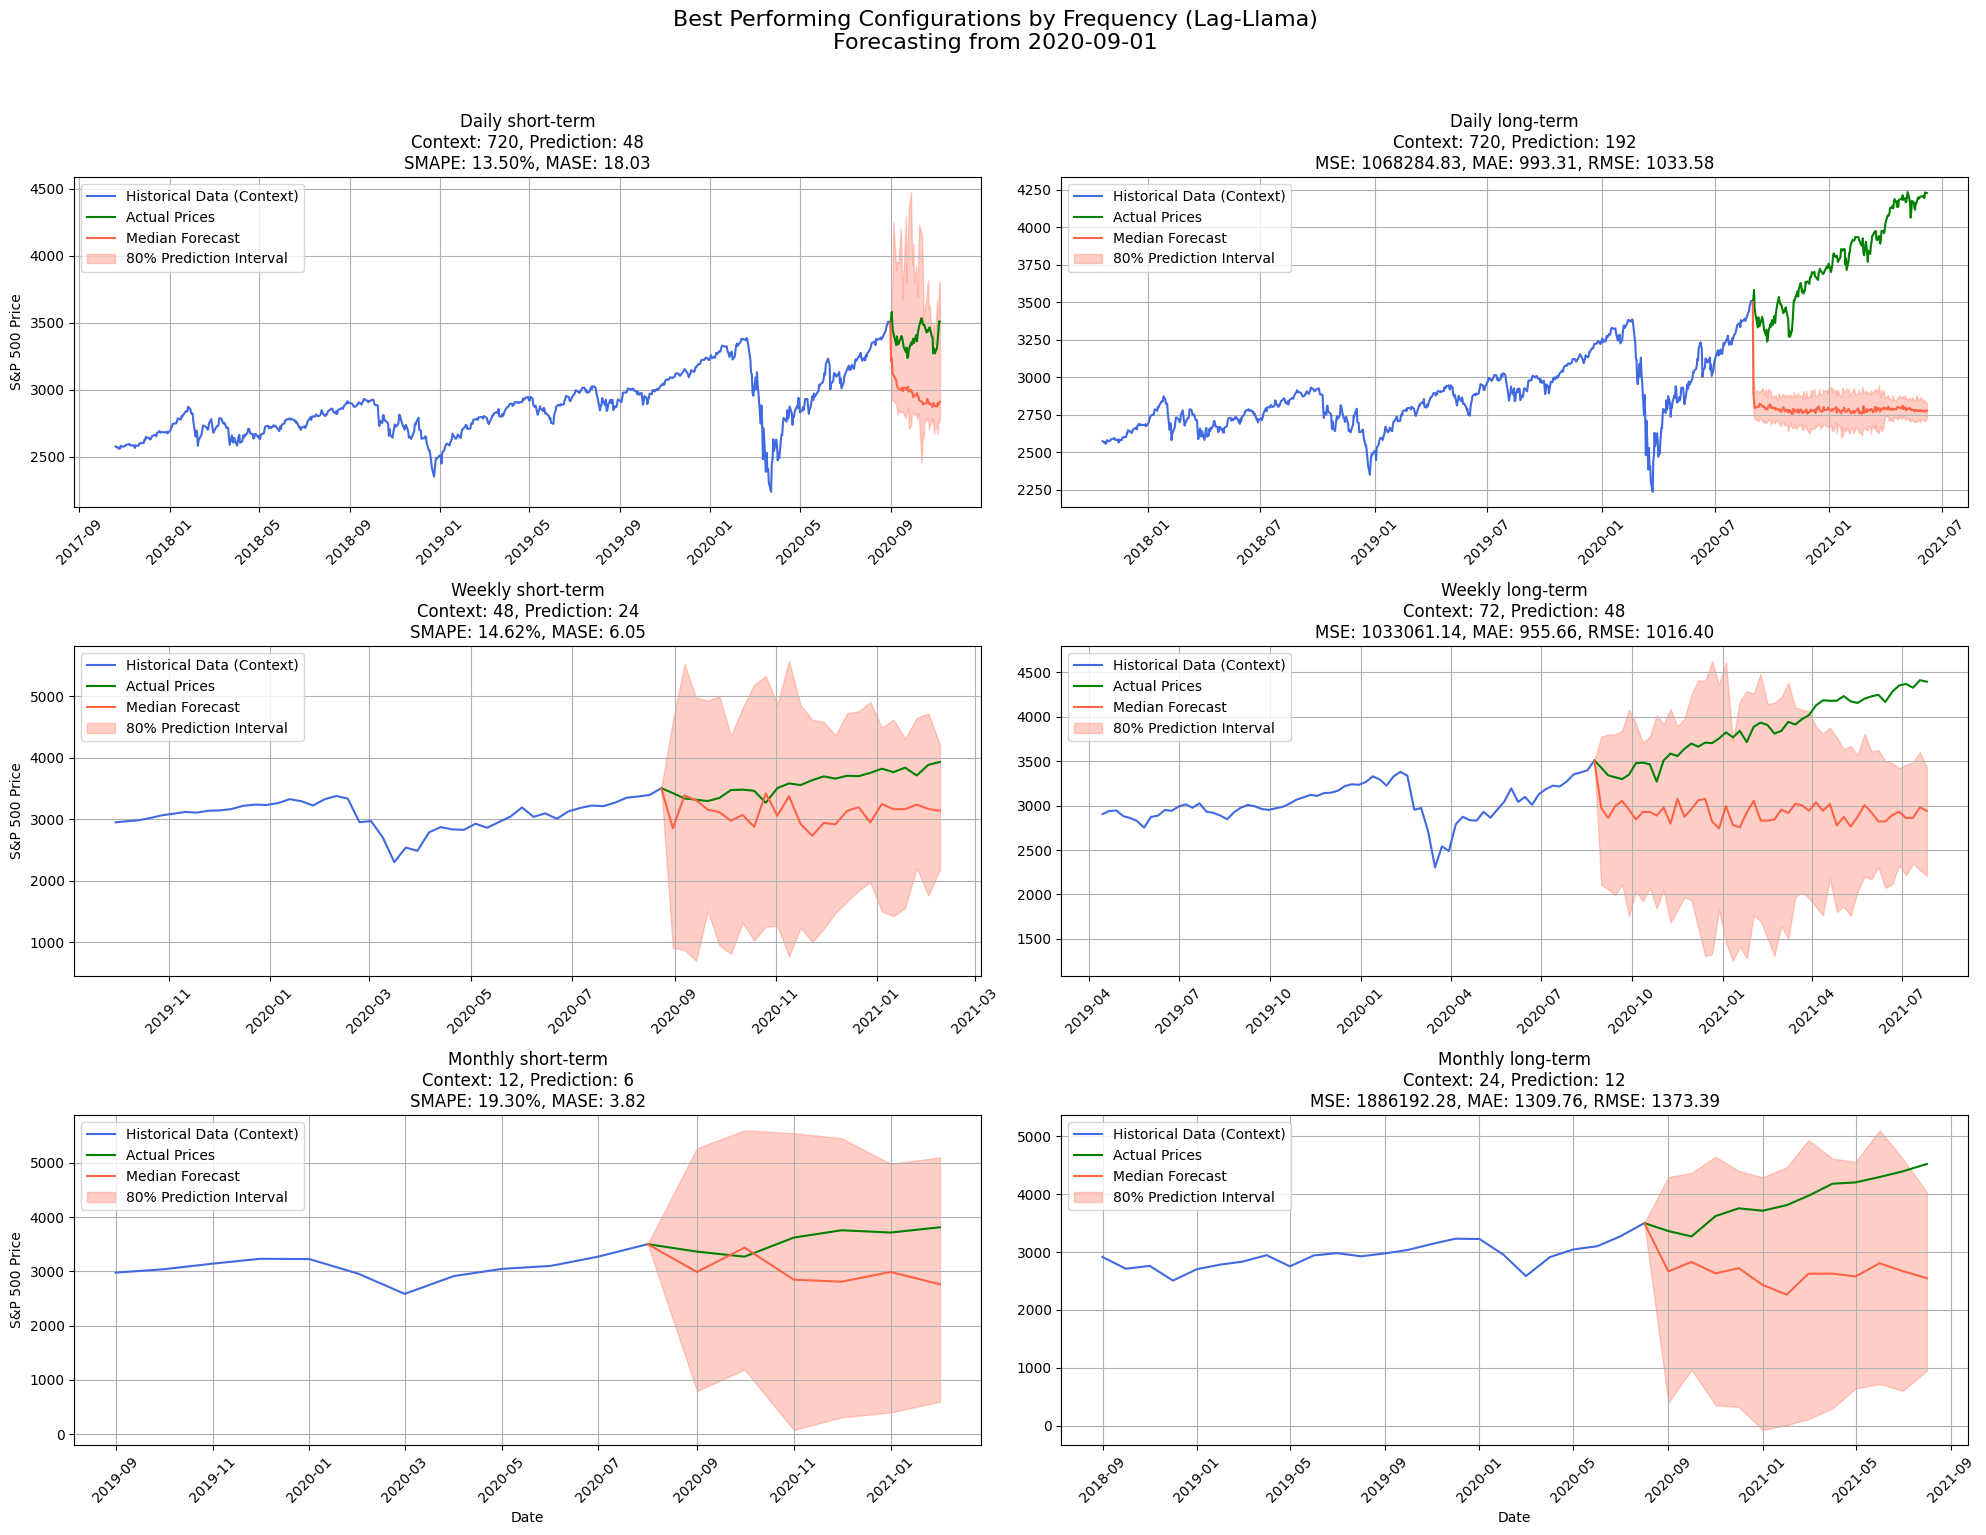


Metrics Comparison - Extended Period vs COVID Period:

Daily Frequency Results:

Short-term metrics:
Extended Period (forecast from 2024-01-01):
context: 720.0000
prediction: 48.0000
MSE: 197598.1988
MAE: 429.4922
RMSE: 444.5202
SMAPE: 13.5026
MASE: 18.0316

COVID Period (forecast from 2021-03-01):
context: 720.0000
prediction: 48.0000
MSE: 197598.1988
MAE: 429.4922
RMSE: 444.5202
SMAPE: 13.5026
MASE: 18.0316

Long-term metrics:
Extended Period (forecast from 2024-01-01):
context: 720.0000
prediction: 192.0000
MSE: 1068284.8281
MAE: 993.3069
RMSE: 1033.5787
SMAPE: 29.9508
MASE: 41.7025

COVID Period (forecast from 2021-03-01):
context: 720.0000
prediction: 192.0000
MSE: 1068284.8281
MAE: 993.3069
RMSE: 1033.5787
SMAPE: 29.9508
MASE: 41.7025

Weekly Frequency Results:

Short-term metrics:
Extended Period (forecast from 2024-01-01):
context: 48.0000
prediction: 24.0000
MSE: 304713.3721
MAE: 490.0820
RMSE: 552.0085
SMAPE: 14.6248
MASE: 6.0488

COVID Period (forecast from 2021-03-01):
con

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator

from data.snp500 import snp500_daily, snp500_monthly, snp500_weekly
from utils.metrics import metric

def calculate_metrics(actual, predicted, insample=None):
    """Calculate metrics dynamically"""
    mae, mse, rmse, mape, mspe = metric(predicted, actual)
    smape = 200 * np.mean(np.abs(predicted - actual) / (np.abs(predicted) + np.abs(actual)))
    
    if insample is not None:
        naive_forecast = insample[:-1]
        naive_target = insample[1:]
        naive_mae = np.mean(np.abs(naive_target - naive_forecast))
        mase = mae / naive_mae if naive_mae != 0 else np.nan
    else:
        mase = np.nan
        
    return {"MSE": mse, "MAE": mae, "RMSE": rmse, "SMAPE": smape, "MASE": mase}

def lag_llama_forecast(context, prediction_window, freq="D"):
    """Forecast function for Lag-Llama model"""
    context = np.asarray(context).flatten()
    dates = pd.date_range(end=pd.Timestamp.now(), periods=len(context), freq=freq)
    context_series = pd.Series(context, index=dates)
    
    ckpt = torch.load("weights/lag-llama.ckpt", map_location=torch.device("mps"))
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
    
    estimator = LagLlamaEstimator(
        ckpt_path="weights/lag-llama.ckpt",
        prediction_length=prediction_window,
        context_length=len(context),
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (len(context) + prediction_window) / estimator_args["context_length"]),
        },
        device=torch.device("mps"),
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    dataset = ListDataset([{"start": str(dates[0]), "target": context}], freq=freq)
    forecast_it, ts_it = make_evaluation_predictions(dataset=dataset, predictor=predictor, num_samples=100)
    forecasts = list(forecast_it)
    forecast_samples = forecasts[0].samples

    low, median, high = np.percentile(forecast_samples, [10, 50, 90], axis=0)
    return low, median, high

def plot_best_configs(data_dict, configs_dict, forecast_point, time_period):
    """Plot best performing configurations for each frequency"""
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle(f"Best Performing Configurations by Frequency (Lag-Llama)\nForecasting from {forecast_point}", fontsize=16, y=1.02)
    
    plot_idx = 1
    freq_map = {"daily": "D", "weekly": "W", "monthly": "M"}
    
    for freq in ["daily", "weekly", "monthly"]:
        data = data_dict[freq].copy()
        if isinstance(data.index, pd.DatetimeIndex):
            data = data.reset_index()
        if not pd.api.types.is_datetime64_any_dtype(data["Date"]):
            data["Date"] = pd.to_datetime(data["Date"])
            
        period_data = data[(data["Date"] >= time_period[0]) & (data["Date"] <= time_period[1])].reset_index(drop=True)
        forecast_start_idx = period_data[period_data["Date"] <= forecast_point].index[-1]
        
        for term in ["short", "long"]:
            ax = plt.subplot(3, 2, plot_idx)
            context_window = configs_dict[freq][term]["context"]
            prediction_window = configs_dict[freq][term]["prediction"]
            
            if forecast_start_idx < context_window:
                ax.text(0.5, 0.5, f"Insufficient historical data for {freq} {term}-term\nNeed {context_window} points before {forecast_point}",
                       horizontalalignment="center", verticalalignment="center", transform=ax.transAxes)
                plot_idx += 1
                continue
                
            window_start = forecast_start_idx - context_window
            window_end = min(forecast_start_idx + prediction_window + 1, len(period_data))
            window_data = period_data.iloc[window_start:window_end].copy()
            
            if len(window_data) < context_window + prediction_window:
                ax.text(0.5, 0.5, f"Insufficient data for full prediction window\nNeed {context_window + prediction_window} points, have {len(window_data)}",
                       horizontalalignment="center", verticalalignment="center", transform=ax.transAxes)
                plot_idx += 1
                continue
                
            context = window_data["Close"].values[:context_window]
            low, median, high = lag_llama_forecast(context, prediction_window, freq=freq_map[freq])
            
            actual_values = window_data["Close"].values[context_window:context_window + prediction_window]
            insample_data = window_data["Close"].values[:context_window]
            metrics = calculate_metrics(actual_values, median, insample=insample_data)
            configs_dict[freq][term].update(metrics)
            
            last_context_point = window_data["Close"].iloc[context_window - 1]
            plot_actual = np.insert(actual_values[:prediction_window], 0, last_context_point)
            plot_median = np.insert(median[:prediction_window], 0, last_context_point)
            plot_low = np.insert(low[:prediction_window], 0, last_context_point)
            plot_high = np.insert(high[:prediction_window], 0, last_context_point)
            
            historical_dates = window_data["Date"].iloc[:context_window]
            forecast_dates = window_data["Date"].iloc[context_window-1:context_window + prediction_window]
            
            ax.plot(historical_dates, window_data["Close"].iloc[:context_window], color="royalblue", label="Historical Data (Context)")
            ax.plot(forecast_dates, plot_actual, color="green", label="Actual Prices")
            ax.plot(forecast_dates, plot_median, color="tomato", label="Median Forecast")
            ax.fill_between(forecast_dates, plot_low, plot_high, color="tomato", alpha=0.3, label="80% Prediction Interval")
            
            if term == "short":
                title = (f"{freq.capitalize()} {term}-term\nContext: {context_window}, Prediction: {prediction_window}\n"
                        f'SMAPE: {metrics["SMAPE"]:.2f}%, MASE: {metrics["MASE"]:.2f}')
            else:
                title = (f"{freq.capitalize()} {term}-term\nContext: {context_window}, Prediction: {prediction_window}\n"
                        f'MSE: {metrics["MSE"]:.2f}, MAE: {metrics["MAE"]:.2f}, RMSE: {metrics["RMSE"]:.2f}')
                
            ax.set_title(title)
            ax.tick_params(axis="x", rotation=45)
            if plot_idx % 2 == 1:
                ax.set_ylabel("S&P 500 Price")
            if plot_idx >= 5:
                ax.set_xlabel("Date")
            ax.grid(True)
            ax.legend(loc="upper left")
            
            plot_idx += 1
            
    plt.tight_layout()
    plt.show()
    return configs_dict

# Define best configurations based on results
configs_dict = {
    "daily": {
        "short": {"context": 720, "prediction": 48},
        "long": {"context": 720, "prediction": 192},
    },
    "weekly": {
        "short": {"context": 48, "prediction": 24},
        "long": {"context": 72, "prediction": 48},
    },
    "monthly": {
        "short": {"context": 12, "prediction": 6},
        "long": {"context": 24, "prediction": 12},
    },
}

data_dict = {"daily": snp500_daily, "weekly": snp500_weekly, "monthly": snp500_monthly}

# Extended period analysis
print("Generating plots for extended period...")
extended_configs = plot_best_configs(
    data_dict,
    configs_dict.copy(),
    forecast_point="2023-06-01",
    time_period=("2018-01-01", "2024-12-31"),
)

# COVID period analysis
print("\nGenerating plots for COVID period...")
covid_configs = plot_best_configs(
    data_dict,
    configs_dict.copy(),
    forecast_point="2020-09-01",
    time_period=("2016-03-01", "2021-12-31"),
)

# Print comparison of metrics
print("\nMetrics Comparison - Extended Period vs COVID Period:")
for freq in ["daily", "weekly", "monthly"]:
    print(f"\n{freq.capitalize()} Frequency Results:")
    for term in ["short", "long"]:
        print(f"\n{term.capitalize()}-term metrics:")
        print("Extended Period (forecast from 2024-01-01):")
        metrics = extended_configs[freq][term]
        for metric_name, value in metrics.items():
            if value is not None:
                print(f"{metric_name}: {value:.4f}")
                
        print("\nCOVID Period (forecast from 2021-03-01):")
        metrics = covid_configs[freq][term]
        for metric_name, value in metrics.items():
            if value is not None:
                print(f"{metric_name}: {value:.4f}")